# 0.0 Imports

## 0.1 Libraries

In [1]:
import math
import random
import pickle
import warnings
import datetime
import inflection

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn as sns

import matplotlib.pyplot as plt
from tabulate             import tabulate
from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from sklearn.ensemble import RandomForestRegressor

from boruta import BorutaPy


from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
#========================================= Rename DataFrame Columns ==========================================#
def rename_columns(df01):
    # snakecase
    snakecase = lambda col: inflection.underscore(col)
    new_columns = list(map(snakecase, df01.columns))

    # rename
    df01.columns = new_columns
    
    return df01



#============================================ Statistical Summary ============================================#
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T
    iqr = pd.DataFrame(q75.reset_index(drop=True) - q25.reset_index(drop=True))

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = q25.reset_index(drop=True) - 1.5 * iqr.reset_index(drop=True)
    high_outliers = q75.reset_index(drop=True) + 1.5 * iqr.reset_index(drop=True)


    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q25, q75, q95, iqr, low_outliers, high_outliers, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '25%', '75%', '95%','IQR', 'Low Outliers', 'High Outliers', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m



#=========================================== Cramer V (Correlation) ===========================================#
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


#========================================== Machine Learning Scores ===========================================#
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
                            'Model_name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse,
                        }, index=[0])


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)



#====================================== Machine Learning Cross Validation ======================================#
def cross_validation(X_training, kfold, model_name, model='default', verbose=False):
    mae_list  = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {kfold+1 - k}')
        # Start and End Date for Validation
        start_date_valid = X_training['date'].max() - datetime.timedelta(days=k*6*7)
        end_date_valid = X_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtering Dataset
        training = X_training[X_training['date'] < start_date_valid]
        validation = X_training[(X_training['date'] >= start_date_valid) & (X_training['date'] <= end_date_valid)]

        # Training and Validation Dataset
        # Training
        X_kfold_training = training.drop(['date', 'sales'], axis=1)
        y_kfold_training = training['sales']

        # Validation
        X_kfold_validation = validation.drop(['date', 'sales'], axis=1)
        y_kfold_validation = validation['sales']

        # Model
        ## Model Map
        model_map = {
            'LinearRegression': LinearRegression(),
            'Lasso': Lasso(alpha=0.01),
            'RandomForestRegressor': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
            'XGBRegressor': XGBRegressor( objective='reg:squarederror', n_estimators=500),
            'LGBMRegressor': LGBMRegressor(n_estimators=500, random_state=42, n_jobs=-1)   
        }
        
        ## Mapped Model
        if model == 'default':
            model = model_map[model_name]
        else: model = model
        
        model.fit(X_kfold_training, y_kfold_training)

        # Prediction
        yhat = model.predict(X_kfold_validation)

        #Performance
        model_result = ml_error(model_name, np.expm1(y_kfold_validation), np.expm1(yhat))
        
        #Store Performance of each KFold iteration
        mae_list.append(model_result['MAE'].tolist())
        mape_list.append(model_result['MAPE'].tolist())
        rmse_list.append(model_result['RMSE'].tolist())


    dict_result = {
                    'Model Name': [model_name],
                    'MAE CV': [np.round(np.mean(mae_list),4).astype(str) + ' +/- ' + np.round(np.std(mae_list),4).astype(str)],
                    'MAPE CV': [np.round(np.mean(mape_list),4).astype(str) + ' +/- ' + np.round(np.std(mape_list),4).astype(str)],
                    'RMSE CV': [np.round(np.mean(rmse_list),4).astype(str) + ' +/- ' + np.round(np.std(rmse_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

In [5]:
sales_raw = pd.read_csv('../01-Data/train.csv', low_memory=False)
store_raw = pd.read_csv('../01-Data/store.csv', low_memory=False)

### 0.3.1 Merge Datasets

In [6]:
df_raw = sales_raw.merge(store_raw, how='left', on='Store')

# 1.0 Data Description

In [7]:
df01 = df_raw.copy()

## 1.1 Columns

In [8]:
df01.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### 1.1.1 Rename Columns

In [9]:
df01 = rename_columns(df01)

### 1.1.2 New Columns Name

In [10]:
df01.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [11]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [12]:
df01.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df01['date'] = pd.to_datetime(df01['date'])

## 1.4 NA Check

In [14]:
df01.isnull().mean()

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## 1.5  Fillout NA

In [15]:
max_value_competition_distance = df01['competition_distance'].max()

In [16]:
    # CompetitionDistance
    #distance in meters to the nearest competitor store
#maxValueCompetitionDistance = dfRaw1['CompetitionDistance'].max()
df01['competition_distance'] = df01['competition_distance'].apply(lambda row: 200000.0 if math.isnan(row) else row)


# CompetitionOpenSinceMonth
    #gives the approximate month of the time the nearest competitor was opened
df01['competition_open_since_month'] = df01.apply(lambda row: row['date'].month if math.isnan(row['competition_open_since_month']) else row['competition_open_since_month'], axis=1)


# CompetitionOpenSinceYear
    # gives the approximate year of the time the nearest competitor was opened
df01['competition_open_since_year'] = df01.apply(lambda row: row['date'].year if math.isnan(row['competition_open_since_year']) else row['competition_open_since_year'], axis=1)


# Promo2SinceWeek
    #describes the calendar week when the store started participating in Promo2
df01['promo2_since_week'] = df01.apply(lambda row: row['date'].week if math.isnan(row['promo2_since_week']) else row['promo2_since_week'], axis=1)


# Promo2SinceYear
    #describes the year when the store started participating in Promo2
df01['promo2_since_year'] = df01.apply(lambda row: row['date'].year if math.isnan(row['promo2_since_year']) else row['promo2_since_year'], axis=1)


# PromoInterval
    #describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.\
    #E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
month_map = {
                1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
            }

df01['promo_interval'].fillna(0, inplace=True)
df01['month_map'] = df01['date'].dt.month.map(month_map)

df01['is_promo'] = df01[['promo_interval', 'month_map']].apply(lambda row: 0 if row['promo_interval'] == 0 else 1 if row['month_map'] in row['promo_interval'].split(',') else 0, axis=1)

## 1.6  Change Types

In [17]:
# competiton
df01['competition_open_since_month'] = df01['competition_open_since_month'].astype(int)
df01['competition_open_since_year'] = df01['competition_open_since_year'].astype(int)

# promo2
df01['promo2_since_week'] = df01['promo2_since_week'].astype(int)
df01['promo2_since_year'] = df01['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [19]:
statistical_summary(num_attributes)

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,25%,75%,95%,IQR,Low Outliers,High Outliers,Std,Relative Std,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,1.0,558.429727,558.0,56.0,280.0,838.0,1060.0,558.0,-557.0,1675.0,321.908493,0.576453,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,4.0,3.998341,4.0,1.0,2.0,6.0,7.0,4.0,-4.0,12.0,1.997390,0.499555,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,0.0,5773.818972,5744.0,0.0,3727.0,7856.0,12137.0,4129.0,-2466.5,14049.5,3849.924283,0.666790,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,0.0,633.145946,609.0,0.0,405.0,837.0,1362.0,432.0,-243.0,1485.0,464.411506,0.733498,1.598650,7.091773
4,open,0.0,1.0,1.0,1.0,0.830107,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.375539,0.452399,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.0,0.381515,0.0,0.0,0.0,1.0,1.0,1.0,-1.5,2.5,0.485758,1.273237,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.0,0.178647,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.383056,2.144211,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,250.0,5935.442677,2330.0,130.0,710.0,6910.0,20620.0,6200.0,-8590.0,16210.0,12547.646829,2.114020,10.242344,147.789712
8,promo2,0.0,1.0,1.0,1.0,0.500564,1.0,0.0,0.0,1.0,1.0,1.0,-1.5,2.5,0.500000,0.998873,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.0,0.165966,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.372050,2.241726,1.795644,1.224338


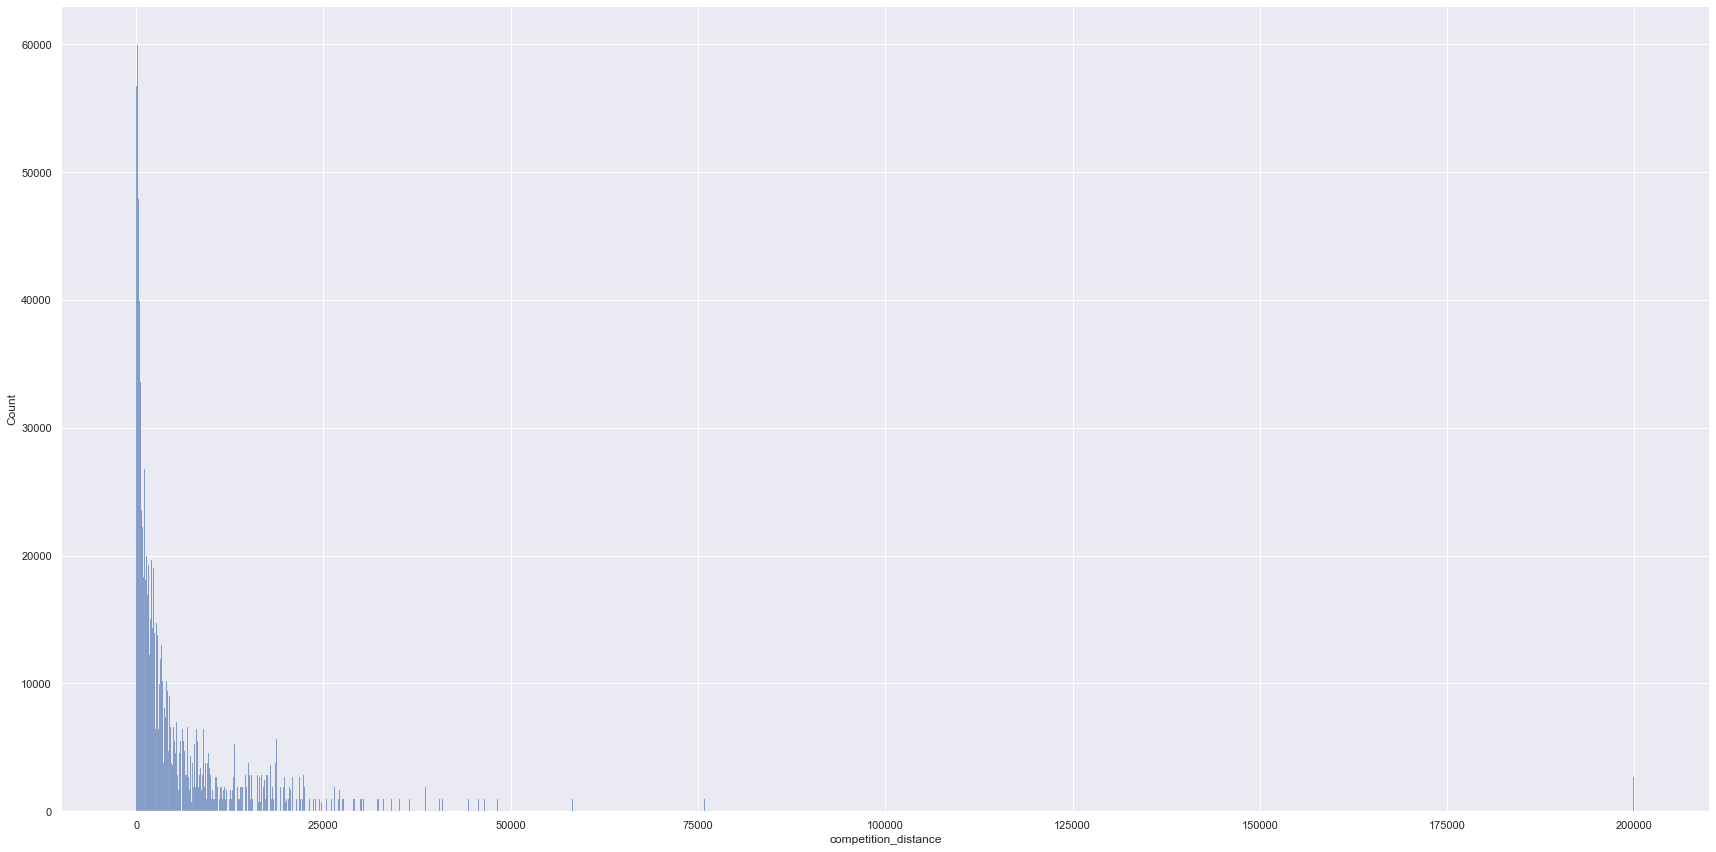

In [20]:
sns.displot(df01['competition_distance'], kde=False, height=12, aspect=2);

### 1.7.2  Categorical Atributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

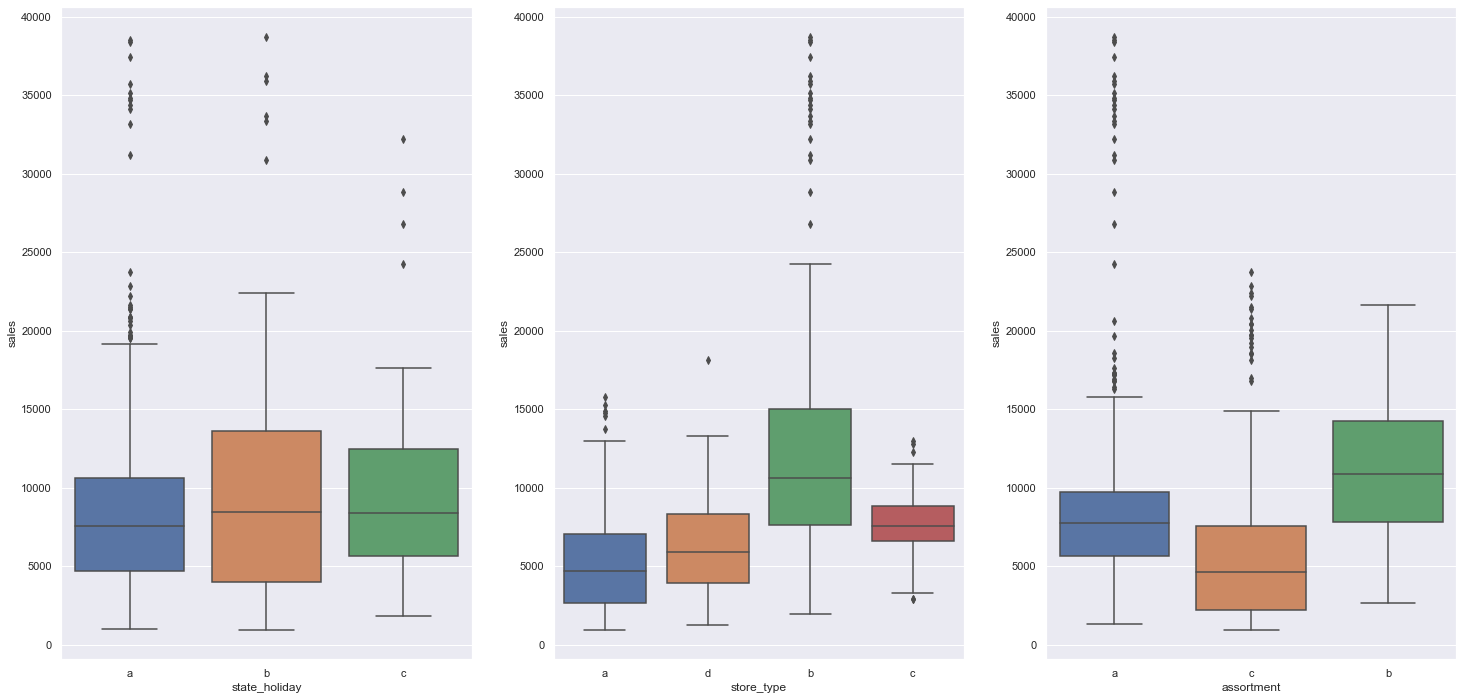

In [22]:
aux = df01[(df01['state_holiday'] != '0') & (df01['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Feature Engineering

In [23]:
df02 = df01.copy()

In [24]:
#year
df02['year'] = df02['date'].dt.year

#month
df02['month'] = df02['date'].dt.month

#day
df02['day'] = df02['date'].dt.day

#week of year
df02['week_of_year'] = df02['date'].dt.weekofyear

#year week
df02['year_week'] = df02['date'].dt.strftime('%Y-%W')

#Competion Sinse
df02['competion_sinse'] = df02.apply(lambda row: datetime.datetime(year=row['competition_open_since_year'], month=row['competition_open_since_month'], day=1), axis=1)
df02['competion_time_month'] = ((df02['date'] - df02['competion_sinse'])/30).apply(lambda row: row.days).astype(int)

#Promo Since
df02['promo_since'] = df02['promo2_since_year'].astype(str) + '-' + df02['promo2_since_week'].astype(str)
df02['promo_since'] = df02['promo_since'].apply(lambda row: datetime.datetime.strptime(row + '-1',  '%Y-%W-%w') - datetime.timedelta(days=7))
df02['promo_time_week'] = ((df02['date'] - df02['promo_since'])/7).apply(lambda row: row.days).astype(int)

#Assortment (level: a = basic, b = extra, c = extended)
level = {
    'a' : 'basic', 'b' : 'extra', 'c' : 'extended'
}
df02['assortment'] = df02['assortment'].map(level)

# State Holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
holiday = {
    'a' : 'public holiday', 'b' : 'Easter holiday', 'c' : 'Christmas'
}
df02['state_holiday'] = df02['state_holiday'].map(holiday)
df02['state_holiday'].fillna('regular day', inplace=True)

In [25]:
df02.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Data Filtering

In [26]:
df03 = df02.copy()

## 3.1 Filtering Rows

In [27]:
df03 = df03[(df03['open'] != 0) & (df03['sales'] > 0)]

## 3.2 Filtering Columns

In [28]:
to_drop = ['customers', 'open', 'promo_interval', 'month_map']
df03.drop(to_drop, axis=1, inplace=True)

# 4.0 Exploratory Data Analysis (EDA)

In [29]:
df04 = df03.copy()

## 4.1 Mind Map Hypothesis

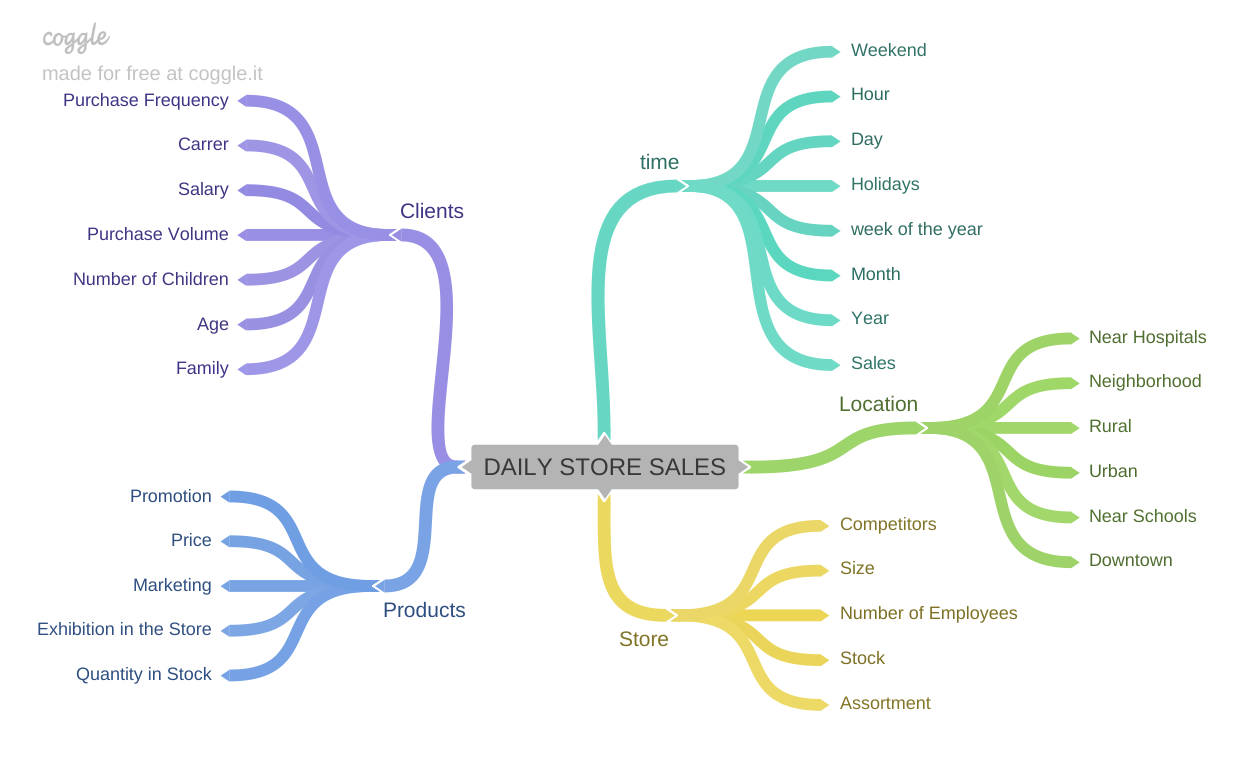

In [30]:
Image('../img/MindMapHypothesis.png')

## 4.2 Formulation of Hypotheses

### 4.2.1 Store Hypothesis

**1.** Stores with larger staff should sell more

**2.** Stores with larger stock should sell more

**3.** Larger stores should sell more

**4.** Smaller stores should sell more

**5.** Stores with larger assortment should sell more

**6.** Stores with closer competitors should sell less

**7.** Stores with longer competitors should sell more

### 4.2.2 Product Hypotesis

**1.** Stores that invest more in marketing should sell more

**2.** Stores that expose more products in the display windows should sell more

**3.** Stores that have lower prices on the products should sell more

**4.** Stores that have lower prices for longer on the products should sell more

**5.** Stores with more aggressive promotions (higher discounts) should sell more

**6.** Stores with active promotions for longer should sell more

**7.** Stores with more days of promotion should sell more

**8.** Stores with consecutive promotions should sell more

### 4.2.3 Time Hypothesis

**1.** Stores that have more holidays should sell less

**2.** Stores that open in the first 6 months should sell more

**3.** Stores that open on weekends should sell more

**4.** Stores open during the Christmas holiday should sell more

**5.** Stores should sell more over the years

**6.** Stores should sell more after the 10th of each month

**7.** Stores should sell less during school holidays

### 4.2.4 Final List of Hypotheses

**Store Hypothesis**

> **1.** Stores with larger assortment should sell more
> 
> **2.** Stores with closer competitors should sell less
> 
> **3.** Stores with longer competitors should sell more

**Product Hypothesis**

> **4.** Stores with active promotions for longer should sell more
> 
> **5.** Stores with more days of promotion should sell more
> 
> **6.** Stores with consecutive promotions should sell more

**Time Hypothesis**

> **7.** Stores that have more holidays should sell less
> 
> **8.** Stores that open in the first 6 months should sell more
> 
> **9.** Stores should sell less on weekends
> 
> **10.** Stores open during the Christmas holiday should sell more
> 
> **11.** Stores should sell more over the years
> 
> **12.** Stores should sell more after the 10th of each month
> 
> **13.** Stores should sell less during school holidays

## 4.3 Univariate Analysis

### 4.3.1 Response Univariate

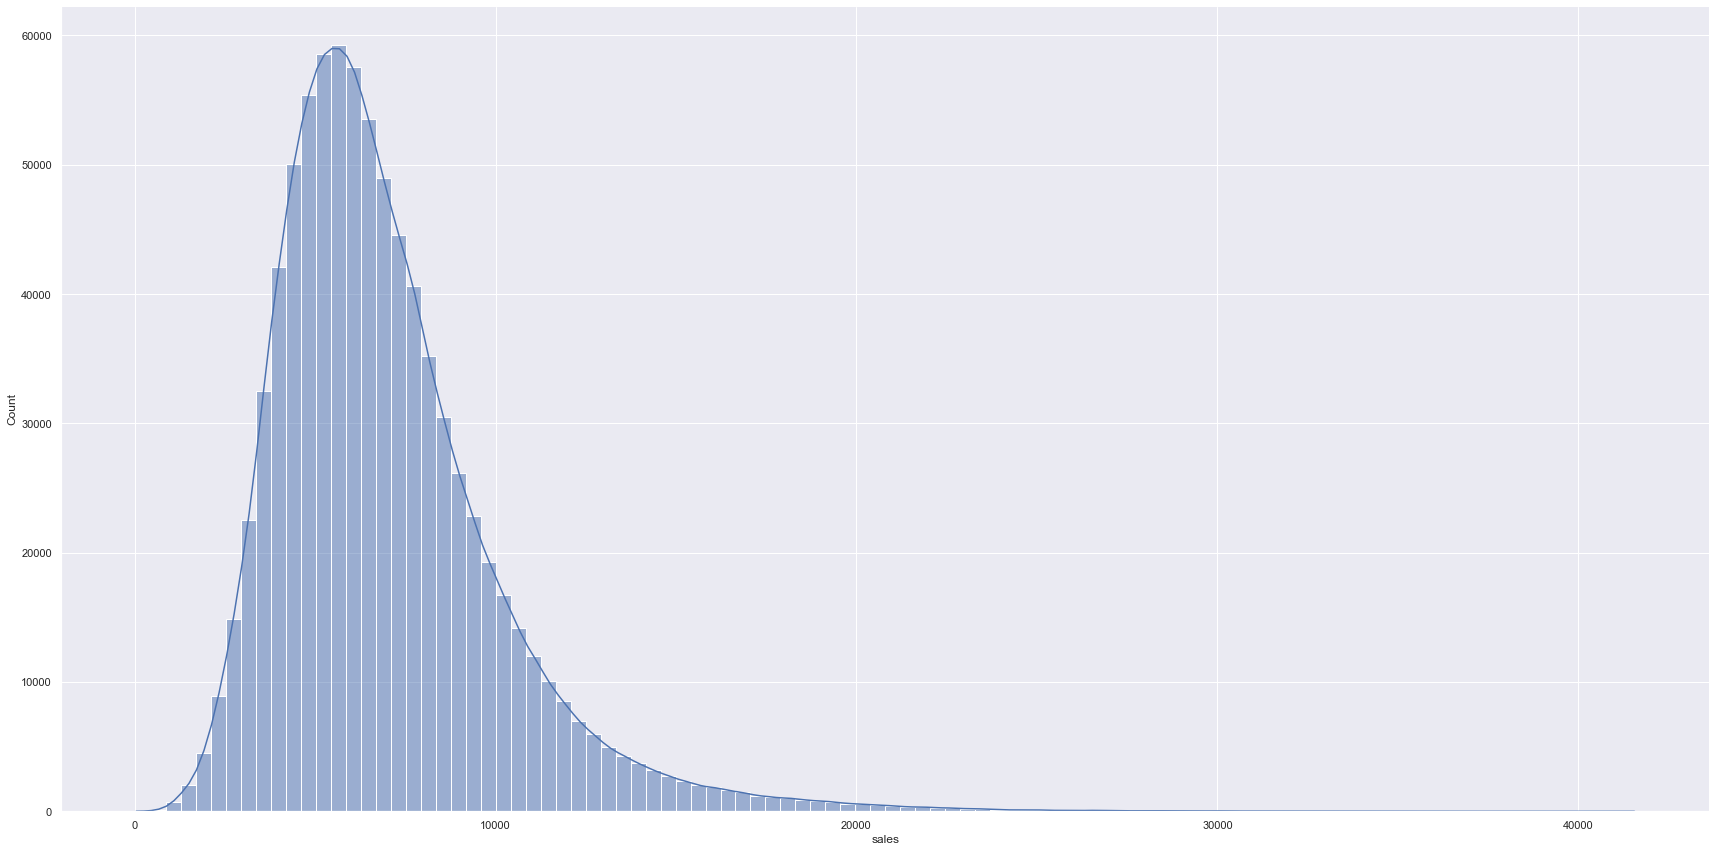

In [31]:
sns.displot(df04['sales'], height=12, aspect=2, bins=100, kde=True);

### 4.3.2 Numerical Variable

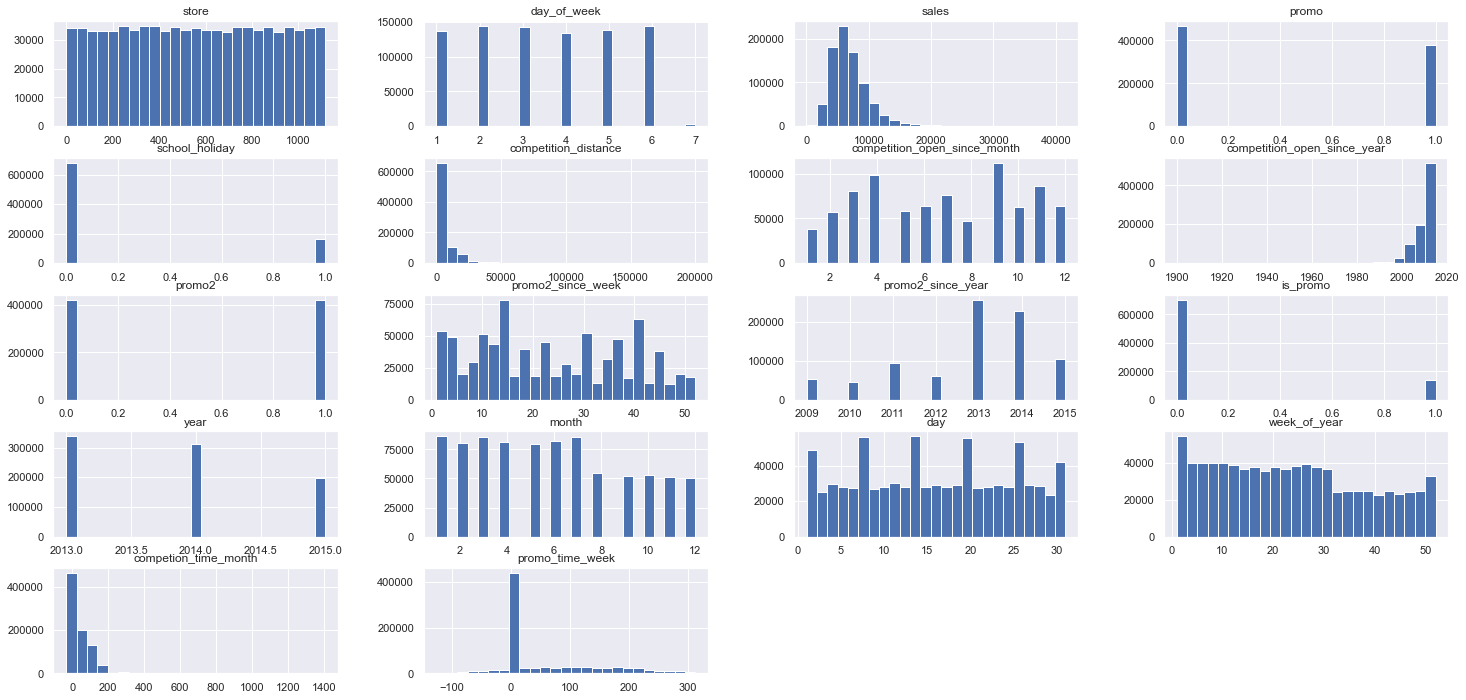

In [32]:
num_attributes = df04.select_dtypes(include=['int32', 'int64', 'float64'])
num_attributes.hist(bins=25);

### 4.3.3 Categorical Variable

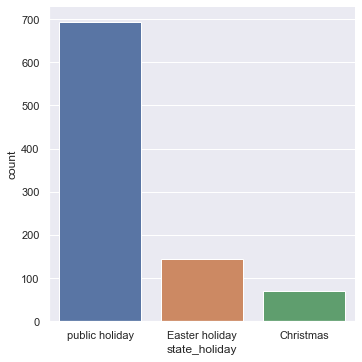

In [33]:
# State Holiday
aux_cat = df04[df04['state_holiday'] != 'regular day']
sns.catplot(x='state_holiday', kind='count', data=aux_cat);

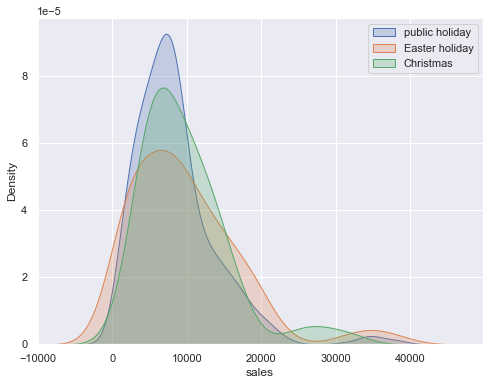

In [34]:
# State Holiday

plt.figure(figsize=(8,6))
sns.kdeplot(df04[df04['state_holiday'] == 'public holiday']['sales'], label='public holiday', shade=True);
sns.kdeplot(df04[df04['state_holiday'] == 'Easter holiday']['sales'], label='Easter holiday', shade=True);
sns.kdeplot(df04[df04['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True);
plt.legend();

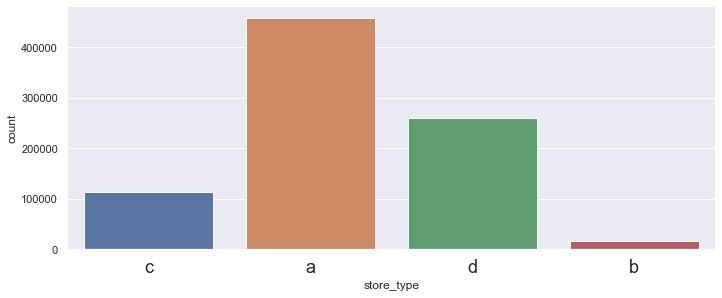

In [35]:
# Store Type

sns.catplot(x='store_type', kind='count', data=df04, height=4, aspect=2.5);
plt.xticks(fontsize=18);

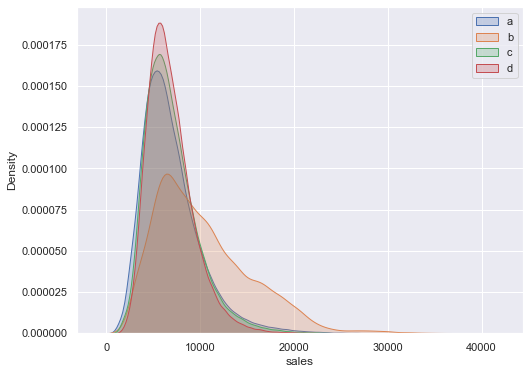

In [36]:
# Store Type

plt.figure(figsize=(8,6))
sns.kdeplot(df04[df04['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df04[df04['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df04[df04['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df04[df04['store_type'] == 'd']['sales'], label='d', shade=True);
plt.legend();

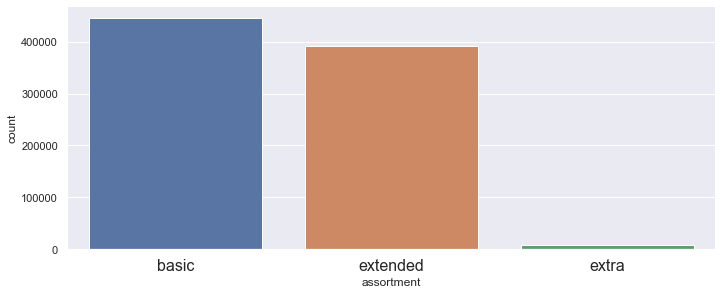

In [37]:
# Assortment

sns.catplot(x='assortment', kind='count', data=df04, height=4, aspect=2.5);
plt.xticks(fontsize=16);

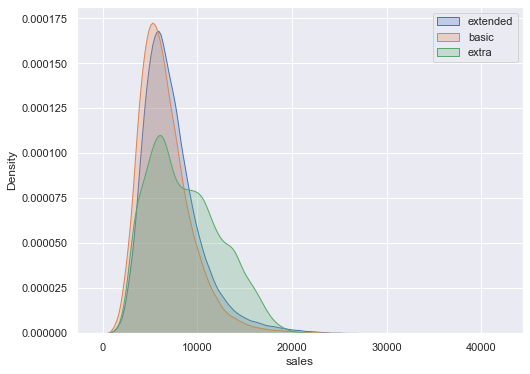

In [38]:
# Assortment

plt.figure(figsize=(8,6))
sns.kdeplot(df04[df04['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df04[df04['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df04[df04['assortment'] == 'extra']['sales'], label='extra', shade=True);
plt.legend();

## 4.4 Bivariate Analysis

### **H01** - H1-Stores with larger assortment should sell more
---
> **Conclusion: FALSE**
>> - Stores with larger assortment sell LESS

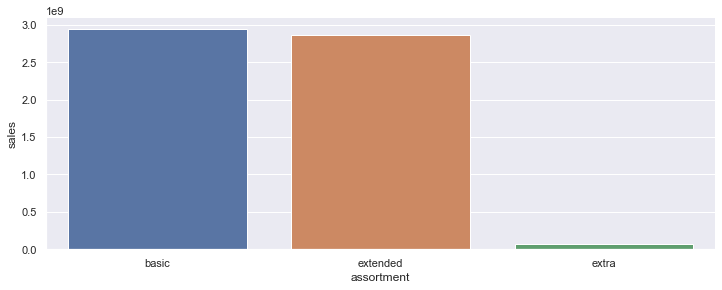

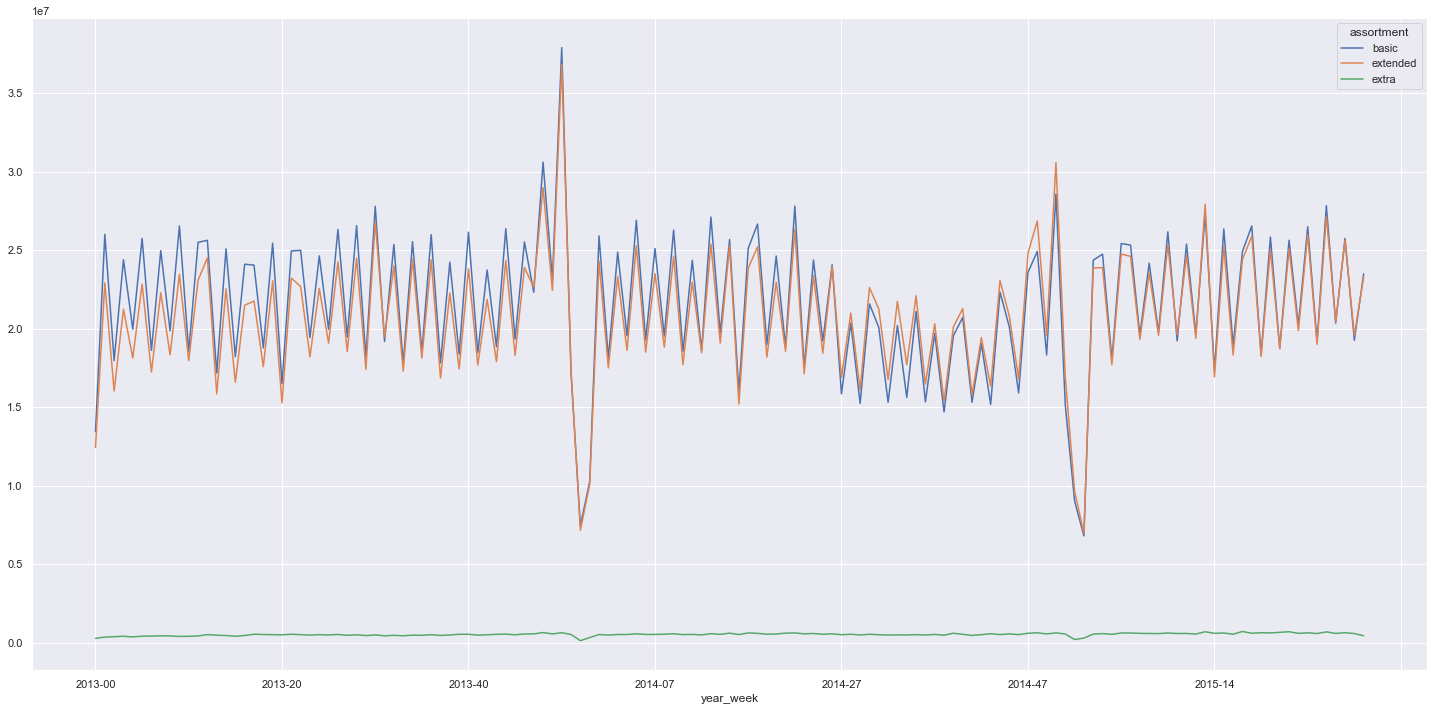

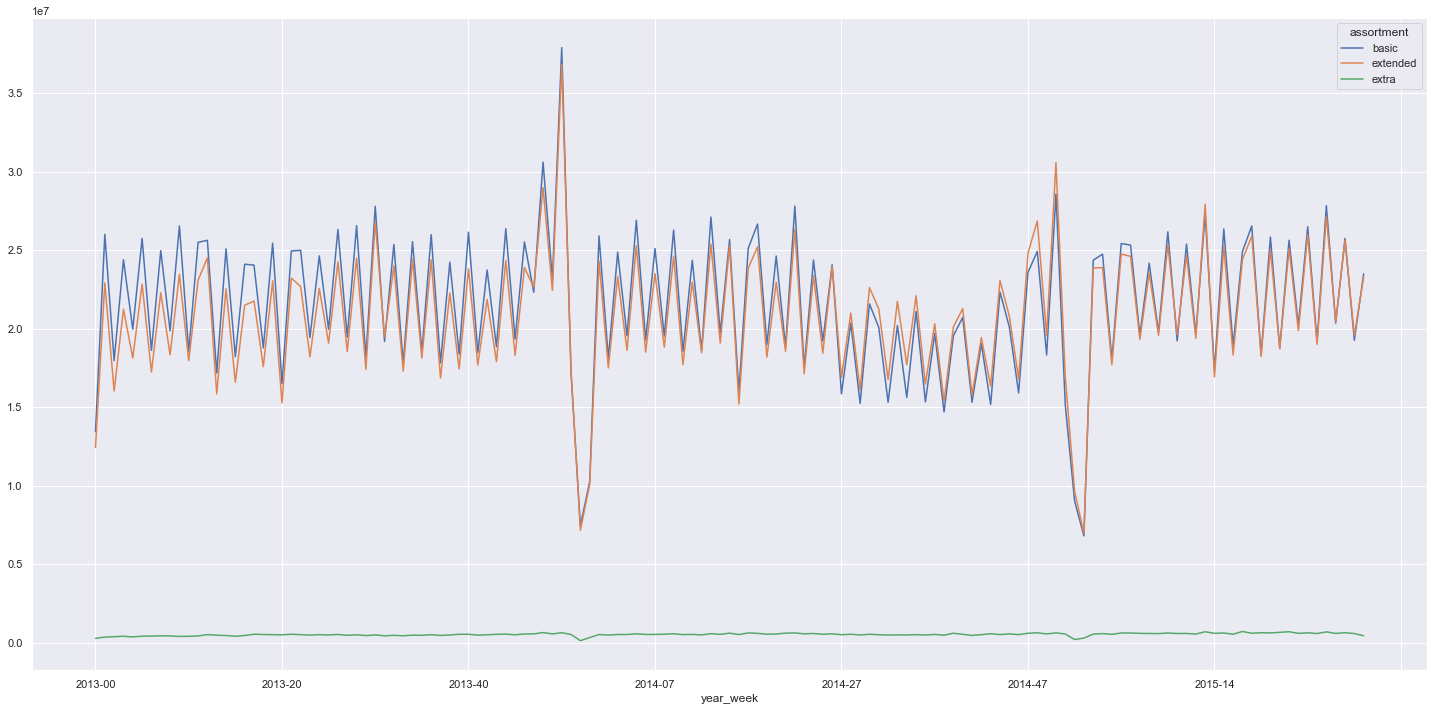

In [39]:
aux01_00 = df04[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.catplot(x='assortment', y='sales', data=aux01_00, kind='bar', height=4, aspect=2.5);


aux01_01 = df04[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux01_01.pivot(index='year_week', columns='assortment', values='sales').plot();


aux01_02 = aux01_01[aux01_01['assortment'] == 'extra']
aux01_01.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H02** - Stores with closer competitors should sell less
---
> **Conclusion: FALSE**
>> - Stores with closer competitors sell MORE

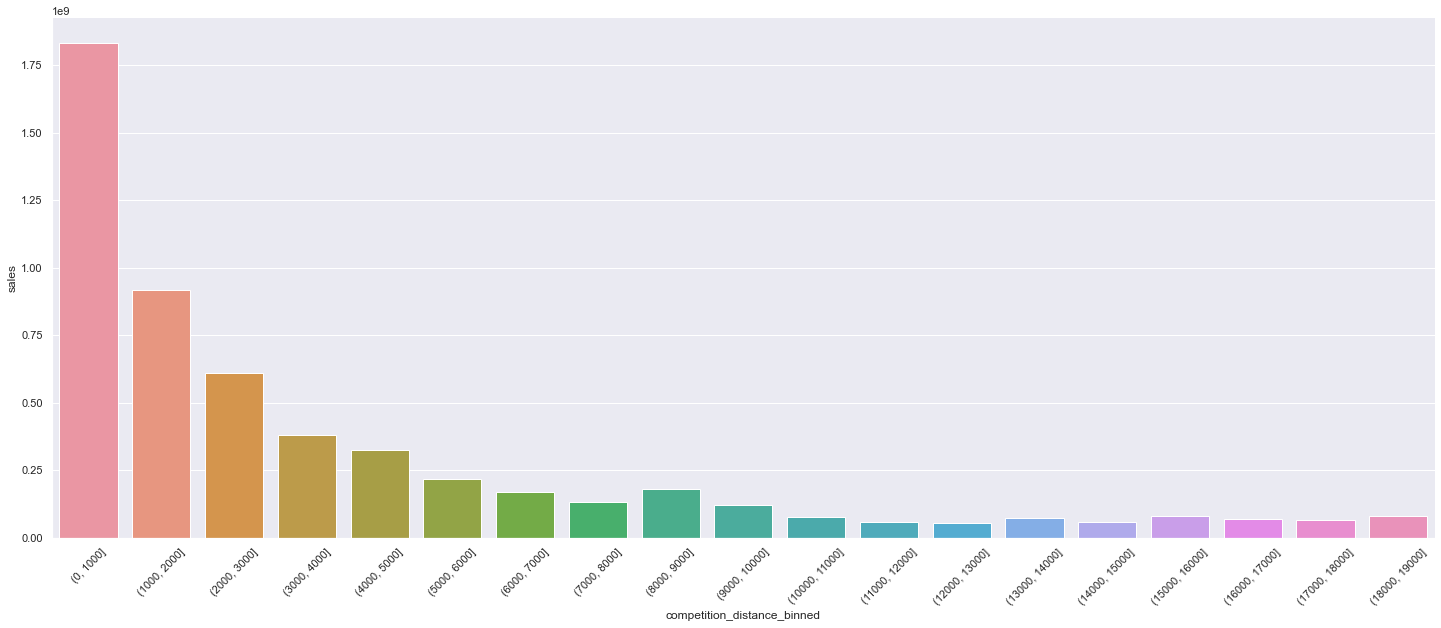

In [40]:
aux02_00 = df04[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux02_00['competition_distance_binned'] = pd.cut(aux02_00['competition_distance'], bins=bins)

aux02_01 = aux02_00[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.catplot(x='competition_distance_binned', y='sales', data=aux02_01, kind='bar', height=8, aspect=2.5);
plt.xticks(rotation=45);

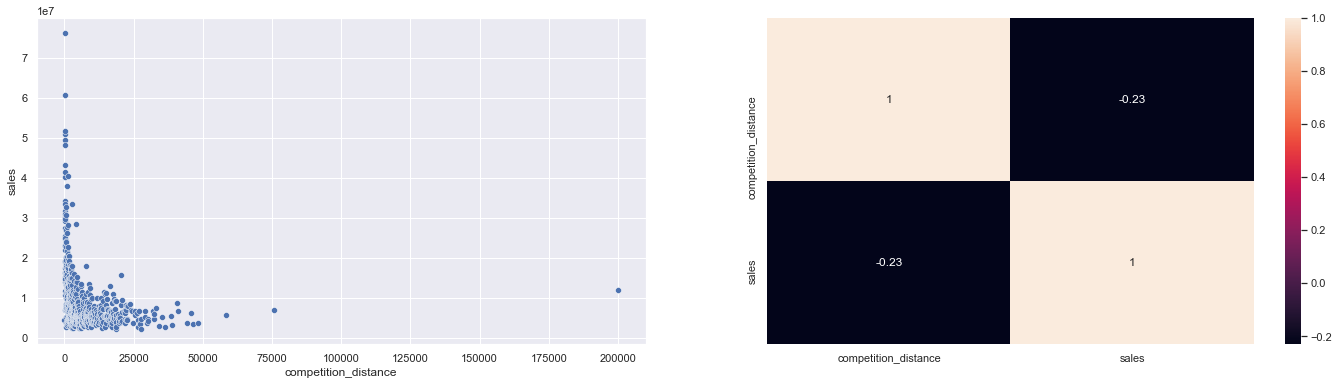

In [41]:
aux02_00 = df04[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize = (24, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux02_00);

plt.subplot(1, 2, 2)
sns.heatmap(aux02_00.corr(method='pearson'), annot=True);

### **H03** - Stores with longer competitors should sell more
---
> **Conclusion: FALSE**
>> - Stores with longer competitors sell LESS

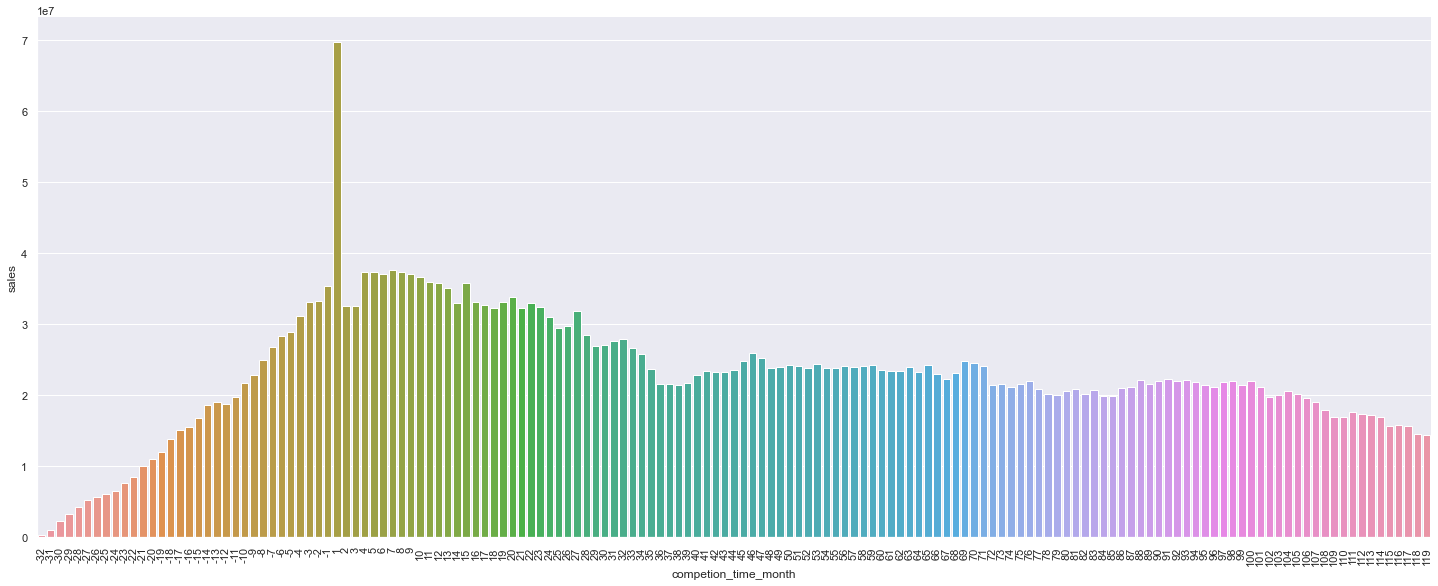

In [42]:
aux03_00 = df04[['competion_time_month', 'sales']].groupby('competion_time_month').sum().reset_index()

aux03_01 = aux03_00[(aux03_00['competion_time_month'] < 120) & (aux03_00['competion_time_month'] != 0)]

sns.catplot(x='competion_time_month', y='sales', data=aux03_01, kind='bar', height=8, aspect=2.5);
plt.xticks(rotation=90);

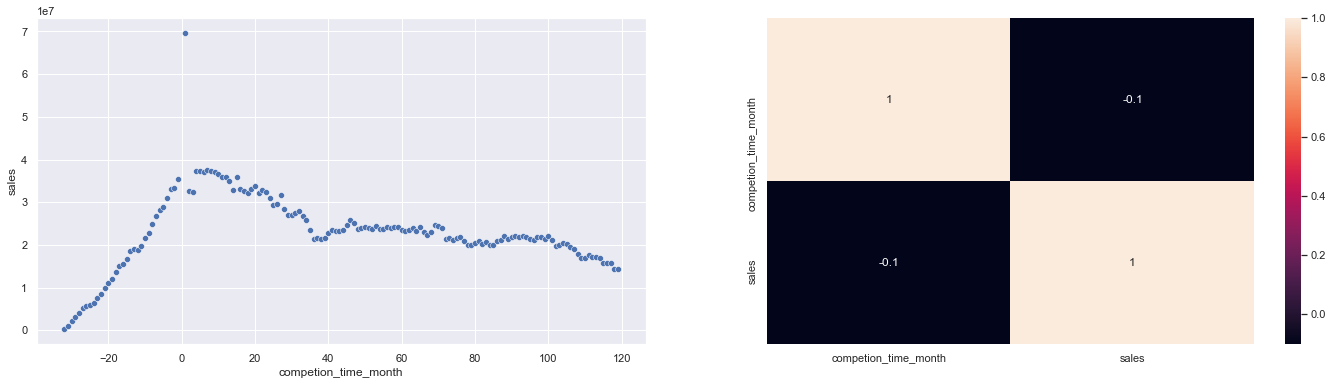

In [43]:
aux03_00 = df04[['competion_time_month', 'sales']].groupby('competion_time_month').sum().reset_index()

aux03_01 = aux03_00[(aux03_00['competion_time_month'] < 120) & (aux03_00['competion_time_month'] != 0)]

plt.figure(figsize = (24, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='competion_time_month', y='sales', data=aux03_01)

plt.subplot(1, 2, 2)
sns.heatmap(aux03_00.corr(method='pearson'), annot=True);

### **H04** - Stores with active promotions for longer should sell more
---
> **Conclusion: FALSE**
>> - Stores with active promotions for longer sell LESS

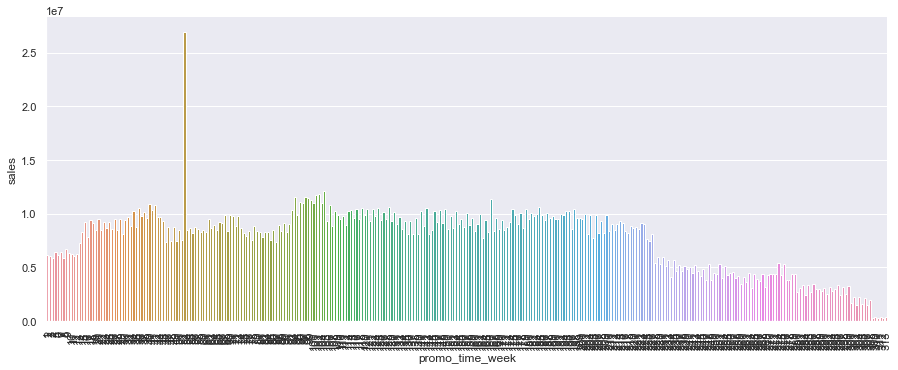

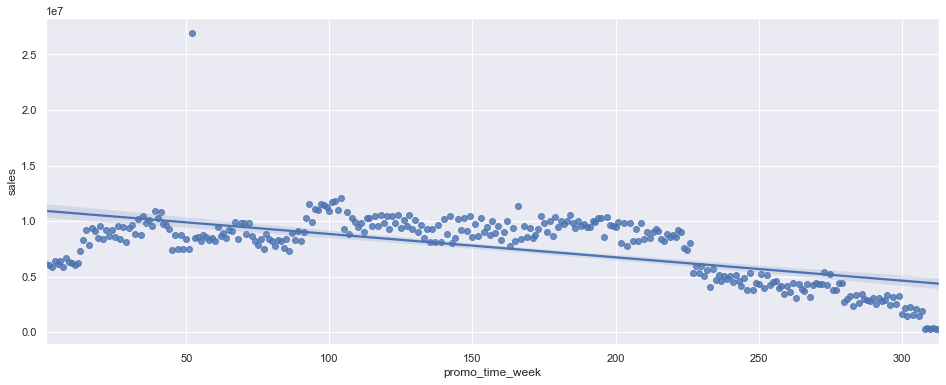

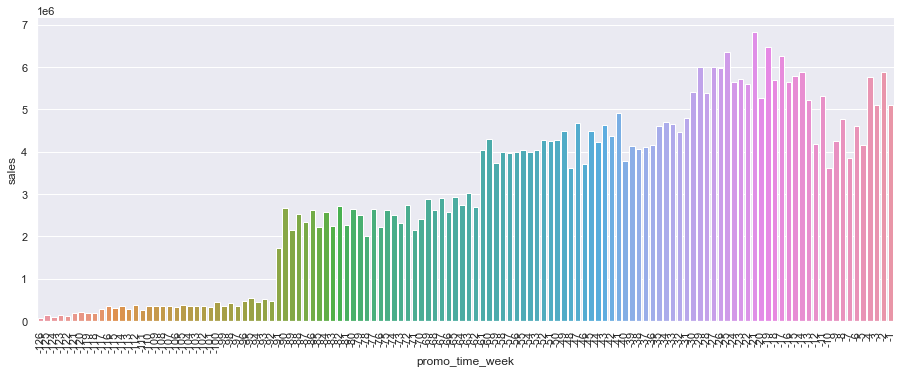

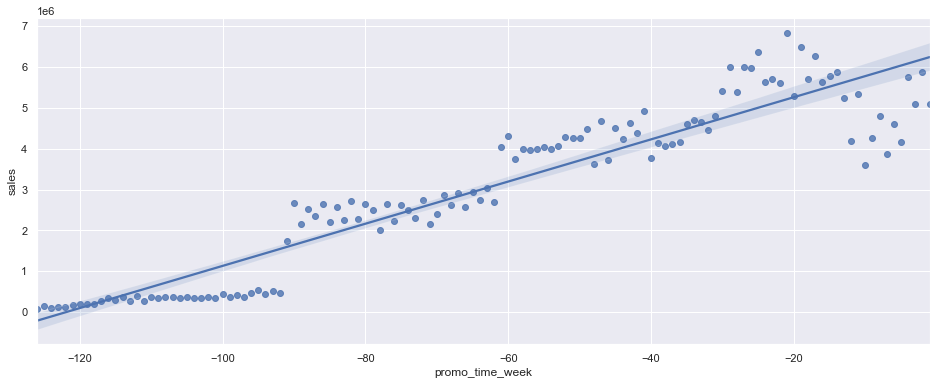

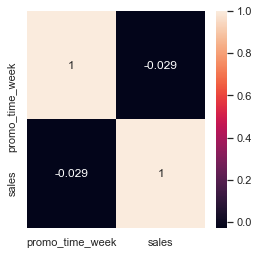

In [44]:
aux04_00 = df04[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux04_01 = aux04_00[aux04_00['promo_time_week'] > 0] #Promo Extended
sns.catplot(x='promo_time_week', y='sales', data=aux04_01, kind='bar', height=5, aspect=2.5);
plt.xticks(rotation=90);

plt.figure(figsize=(16,6))
sns.regplot(x='promo_time_week', y='sales', data=aux04_01);

aux04_02 = aux04_00[aux04_00['promo_time_week'] < 0] #Promo Regular
sns.catplot(x='promo_time_week', y='sales', data=aux04_02, kind='bar', height=5, aspect=2.5);
plt.xticks(rotation=90);

plt.figure(figsize=(16,6))
sns.regplot(x='promo_time_week', y='sales', data=aux04_02);

plt.figure(figsize=(4,4))
sns.heatmap(aux04_00.corr(method='pearson'), annot=True);

### **H05** - ~~Stores with more days of promotion should sell more~~
---
> **Conclusion: inconclusive**

### **H06** - Stores with consecutive promotions should sell more
---
> **Conclusion: FALSE**
>> - Stores with consecutive promotions sell LESS

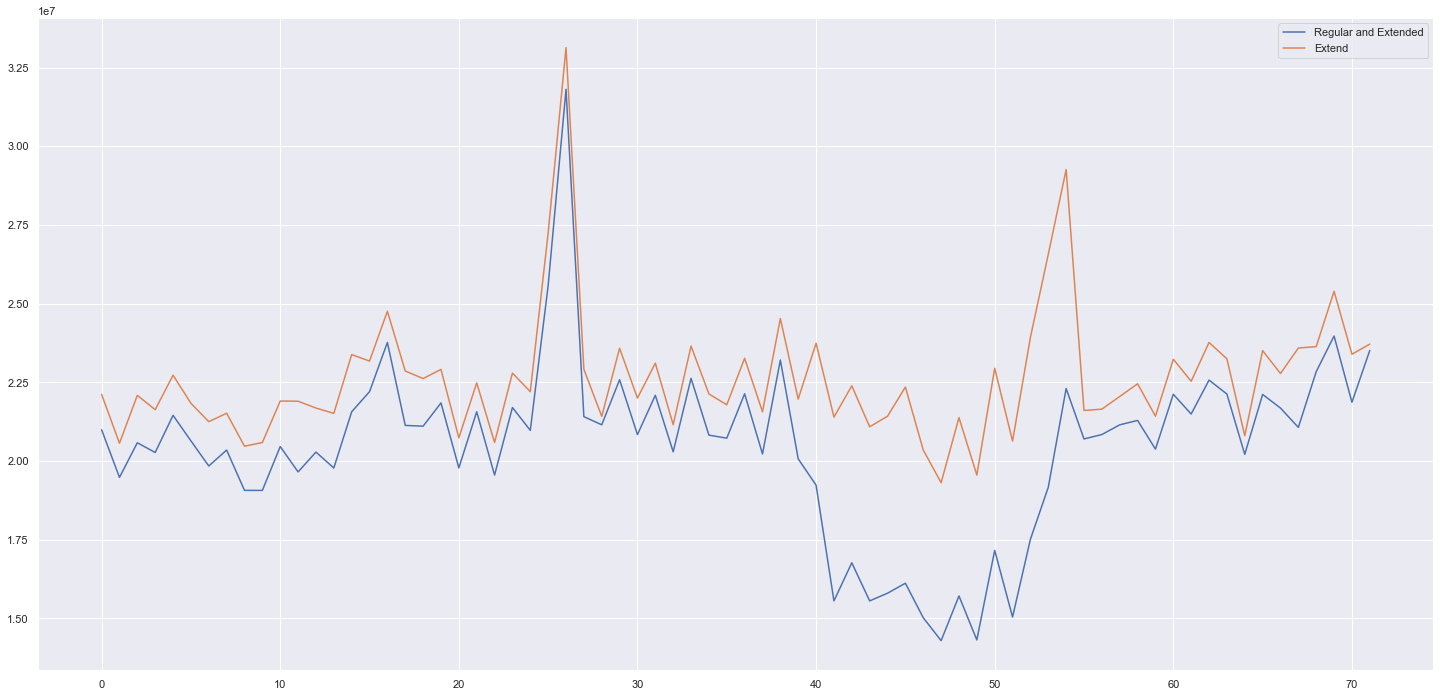

In [45]:
aux06_00 = df04[(df04['promo'] == 1) & (df04['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux06_00.plot()

aux06_01 = df04[(df04['promo'] == 1) & (df04['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux06_01.plot(ax=ax);

ax.legend(labels=['Regular and Extended', 'Extend']);

### **H07** - Stores should sell more in the second semester
---
> **Conclusion: FALSE**
>> - Stores sell LESS in the second semester

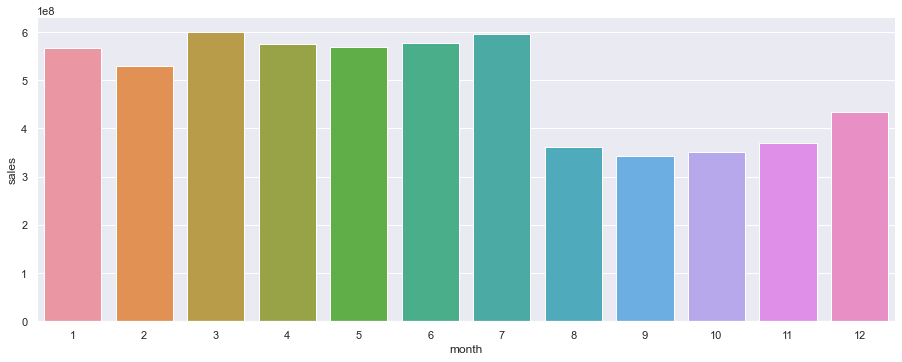

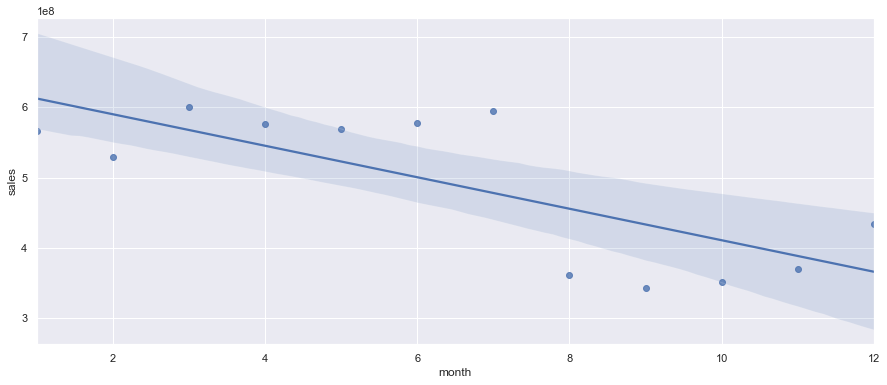

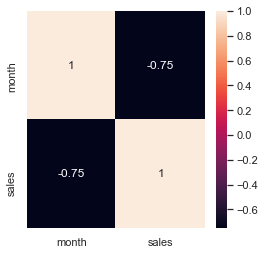

In [46]:
aux07_00 = df04[['month', 'sales']].groupby('month').sum().reset_index()
sns.catplot(x='month', y='sales', data=aux07_00, kind='bar', height=5, aspect=2.5);


plt.figure(figsize=(15,6))
sns.regplot(x='month', y='sales', data=aux07_00);

plt.figure(figsize=(4,4))
sns.heatmap(aux07_00.corr(method='pearson'), annot=True);

### **H08** - Stores should sell less on weekends
---
> **Conclusion: TRUE**
>> - Stores sell LESS on weekends

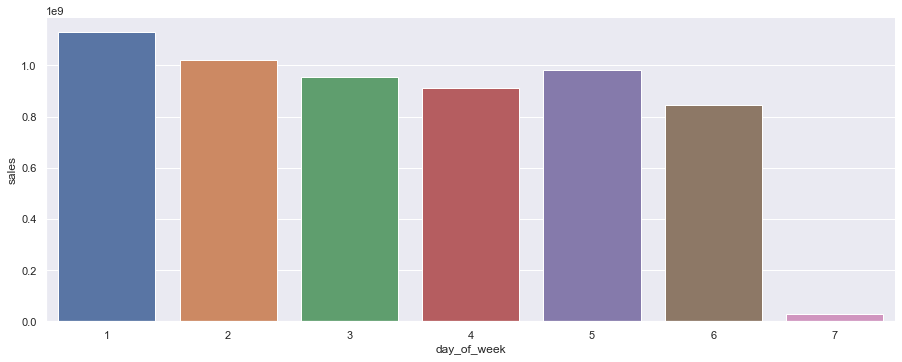

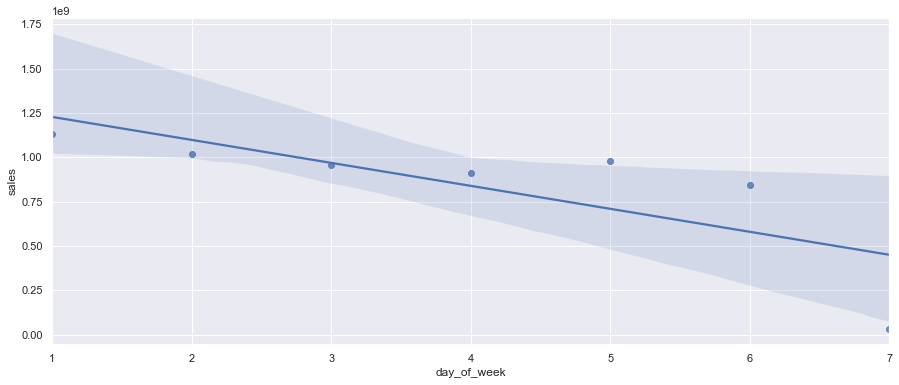

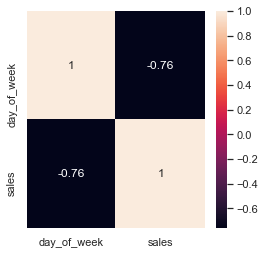

In [47]:
aux08_00 = df04[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.catplot(x='day_of_week', y='sales', data=aux08_00, kind='bar', height=5, aspect=2.5);


plt.figure(figsize=(15,6))
sns.regplot(x='day_of_week', y='sales', data=aux08_00);

plt.figure(figsize=(4,4))
sns.heatmap(aux08_00.corr(method='pearson'), annot=True);

### **H09** - Stores open during the Christmas holiday should sell more
---
> **Conclusion: FALSE**
>> - Stores open during the Christmas holiday sell LESS

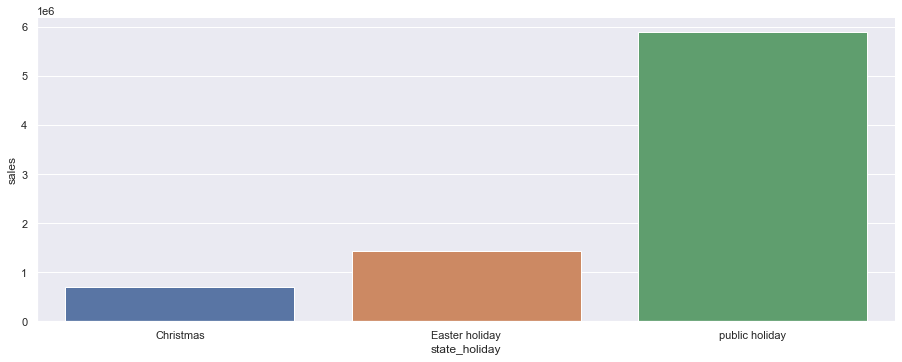

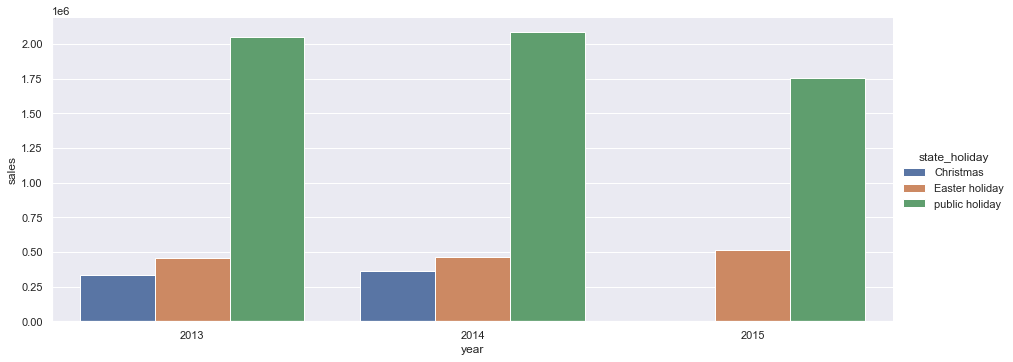

In [48]:
aux09_00 = df04[df04['state_holiday'] != 'regular day']

aux09_01 = aux09_00[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.catplot(x='state_holiday', y='sales', data=aux09_01, kind='bar', height=5, aspect=2.5);

aux09_02 = aux09_00[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.catplot(x='year', y='sales', data=aux09_02, kind='bar', hue='state_holiday', height=5, aspect=2.5);

### **H10** - Stores should sell more over the years
---
> **Conclusion: FALSE**
>> - Stores sell LESS over the years

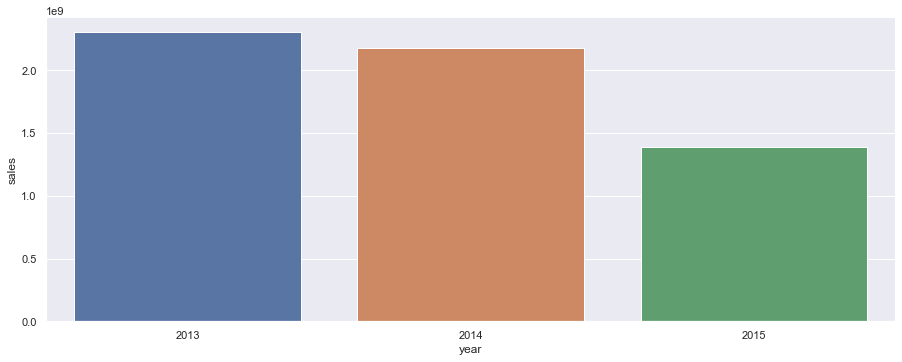

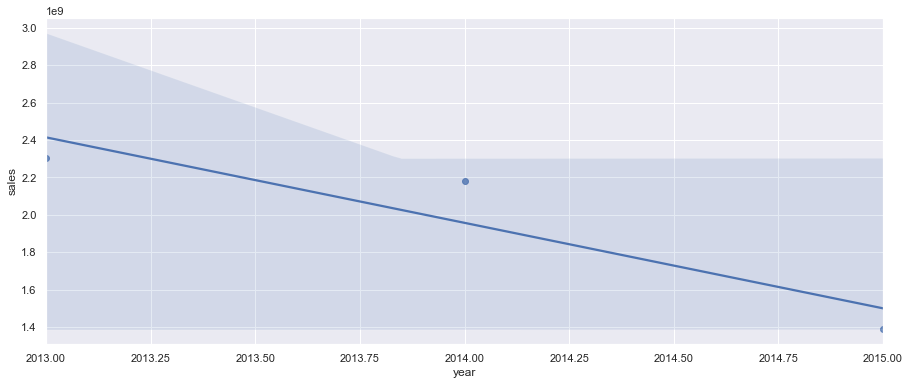

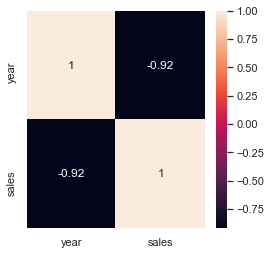

In [49]:
aux10_00 = df04[['year', 'sales']].groupby('year').sum().reset_index()
sns.catplot(x='year', y='sales', data=aux10_00, kind='bar', height=5, aspect=2.5);

plt.figure(figsize=(15,6))
sns.regplot(x='year', y='sales', data=aux10_00);

plt.figure(figsize=(4,4))
sns.heatmap(aux10_00.corr(method='pearson'), annot=True);

### **H11** - Stores should sell more after the 10th of each month
---
> **Conclusion: TRUE**
>> - Stores sell MORE after the 10th of each month

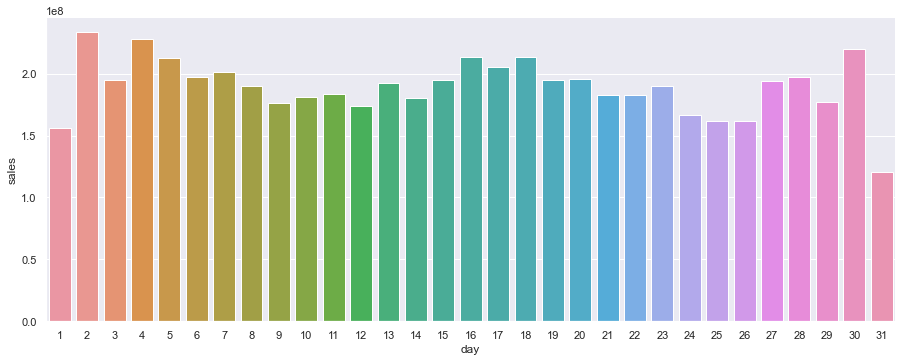

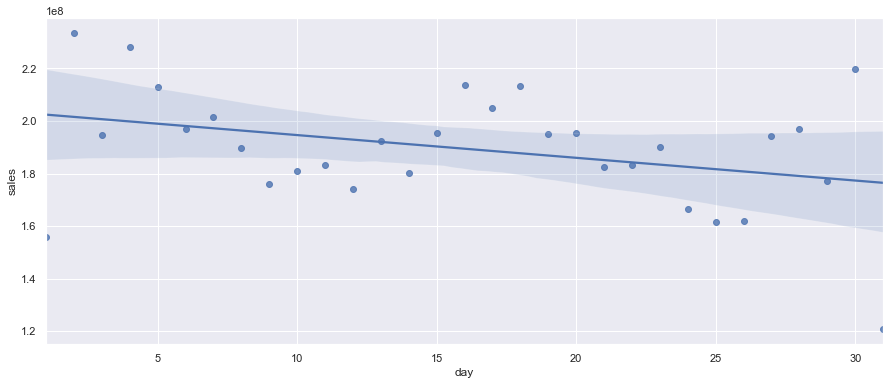

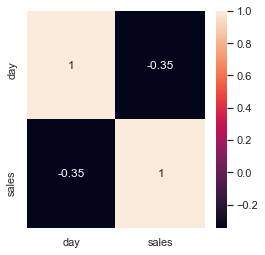

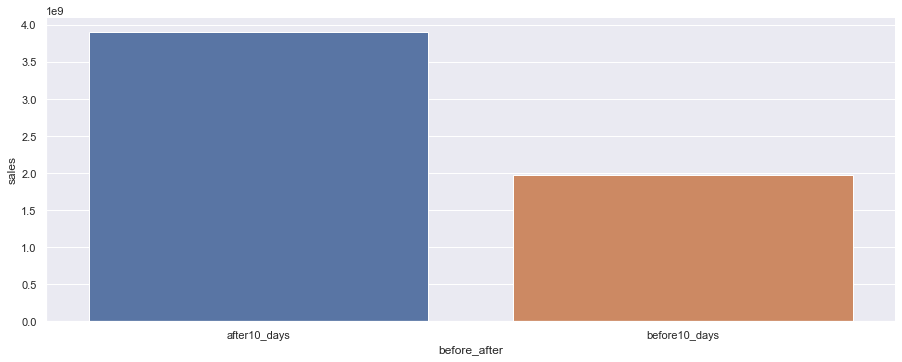

In [50]:
aux11_00 = df04[['day', 'sales']].groupby('day').sum().reset_index()
sns.catplot(x='day', y='sales', data=aux11_00, kind='bar', height=5, aspect=2.5);

plt.figure(figsize=(15,6))
sns.regplot(x='day', y='sales', data=aux11_00);

plt.figure(figsize=(4,4))
sns.heatmap(aux11_00.corr(method='pearson'), annot=True);

aux11_00['before_after'] = aux11_00['day'].apply(lambda row: 'before10_days' if row <= 10 else 'after10_days')
aux11_01 = aux11_00[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.catplot(x='before_after', y='sales', data=aux11_01, kind='bar', height=5, aspect=2.5);

### **H12** - Stores should sell less during school holidays
---
> **Conclusion: TRUE**
>> - Stores sell LESS during school holidays, except July and August

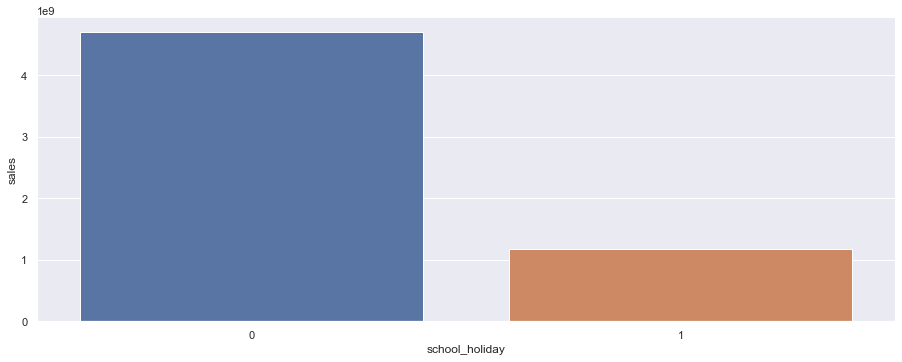

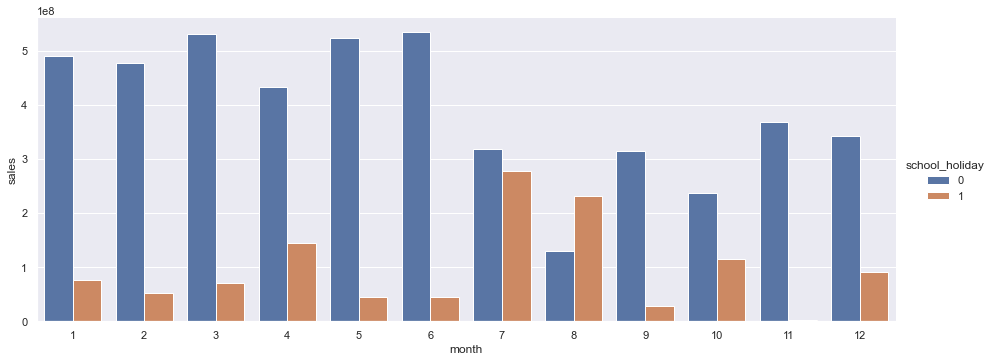

In [51]:
aux12_00 = df04[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.catplot(x='school_holiday', y='sales', data=aux12_00, kind='bar', height=5, aspect=2.5);


aux12_01 = df04[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.catplot(x='month', y='sales', data=aux12_01, kind='bar', hue='school_holiday', height=5, aspect=2.5);

## 4.5 Multivariable analysis

### 4.5.1 Numerical Attributes

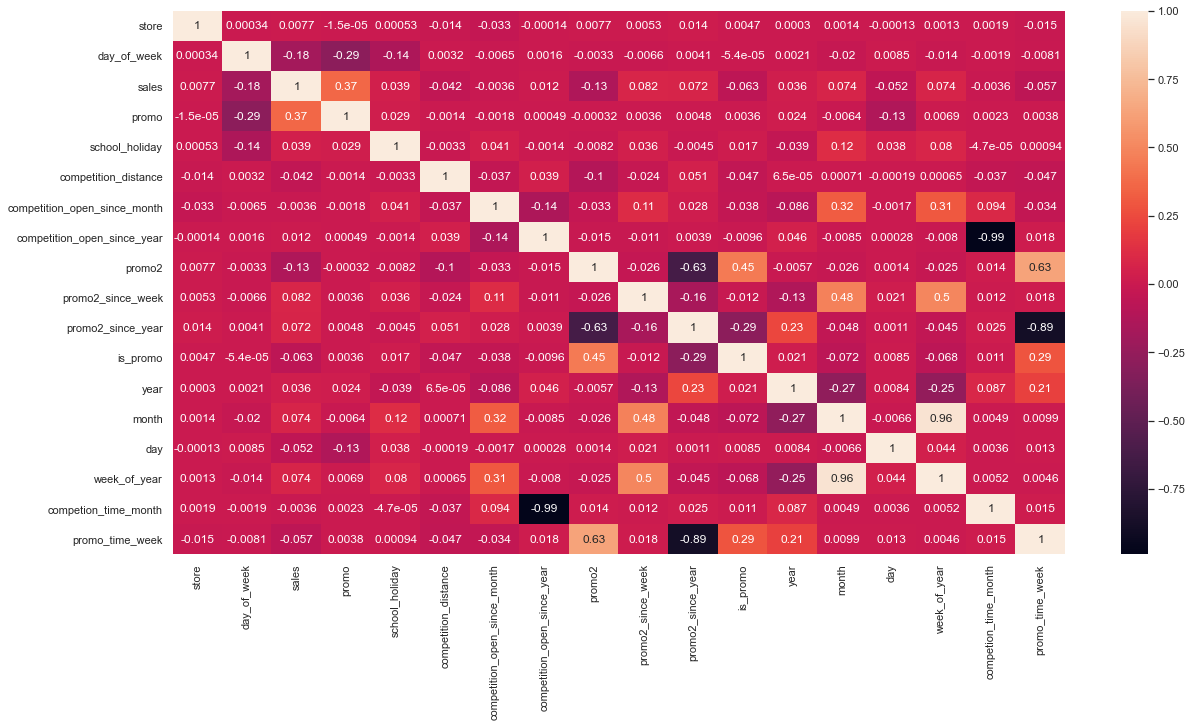

In [52]:
num_attributes = df04.select_dtypes(include=['int32', 'int64', 'float64'])

correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True);

### 4.5.2  Categorical Attributes

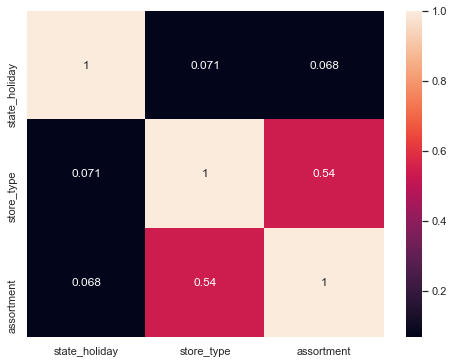

In [53]:
#Only Categorical Data
cat_attributes= df04.select_dtypes(exclude=['int32','int64', 'float64', 'datetime64[ns]'])

#Calculate Cramer V
a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type'])
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])

#Final Dataset
dict_cramer_v = {
                'state_holiday':[a1, a2, a3],
                'store_type':[a4, a5, a6],
                'assortment':[a7, a8, a9]
                }

d = pd.DataFrame(dict_cramer_v)

d = d.set_index(d.columns)

#HeatMap Plot
plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True);

# 5.0 Data Preparation

In [54]:
df05 = df04.copy()

## 5.1 ~~Normalization~~

## 5.2 Rescaling

In [55]:
num_attributes = df05.select_dtypes(include=['int32', 'int64', 'float64'])
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competion_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

#Competion Distance >> Presence of well defined outiliers
num_attributes['competition_distance'] = rs.fit_transform(num_attributes[['competition_distance']].values)
pickle.dump(rs, open('../parameters/1-competition_distance_scaler.pkl', 'wb'))

#Competion Time Month >> Presence of well defined outiliers
num_attributes['competion_time_month'] = rs.fit_transform(num_attributes[['competion_time_month']].values)
pickle.dump(rs, open('../parameters/1-competion_time_month_scaler.pkl', 'wb'))

#Promo Time Week
num_attributes['promo_time_week'] = mms.fit_transform(num_attributes[['promo_time_week']].values)
pickle.dump(mms, open('../parameters/1-promo_time_week_scaler.pkl', 'wb'))

#Year
num_attributes['year'] = mms.fit_transform(num_attributes[['year']].values)
pickle.dump(mms, open('../parameters/1-year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [57]:
#State Holiday -> One Hot Encoding
df05 = pd.get_dummies(df05, prefix=['state_holiday'], columns=['state_holiday'])

#Store Type -> Label Encoding
le = LabelEncoder()
df05['store_type'] = le.fit_transform(df05['store_type'])
pickle.dump(le, open('../parameters/1-store_type_scaler.pkl', 'wb'))

#Assortment -> Ordinal Encoding
dict_assortment = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df05['assortment'] = df05['assortment'].map(dict_assortment)

### 5.3.2 Response Variable Transformation

In [58]:
df05['sales'] = np.log1p(df05['sales'])

### 5.3.3 Nature Transformation

In [59]:
#Month
df05['month_sin'] = df05['month'].apply(lambda row: np.sin(row * (2 * np.pi/12)))
df05['month_cos'] = df05['month'].apply(lambda row: np.cos(row * (2 * np.pi/12)))
#Day
df05['day_sin'] = df05['day'].apply(lambda row: np.sin(row * (2 * np.pi/30)))
df05['day_cos'] = df05['day'].apply(lambda row: np.cos(row * (2 * np.pi/30)))
#Week of Year
df05['week_of_year_sin'] = df05['week_of_year'].apply(lambda row: np.sin(row * (2 * np.pi/52)))
df05['week_of_year_cos'] = df05['week_of_year'].apply(lambda row: np.cos(row * (2 * np.pi/52)))
#Day of Week
df05['day_of_week_sin'] = df05['day_of_week'].apply(lambda row: np.sin(row * (2 * np.pi/7)))
df05['day_of_week_cos'] = df05['day_of_week'].apply(lambda row: np.cos(row * (2 * np.pi/7)))

# 6.0 Feature Selection

In [60]:
to_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competion_sinse', 'year_week']
df06 = df05.drop(to_drop, axis=1)

In [61]:
df06[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [62]:
#Training Dataset
X_Train = df06[df06['date'] < '2015-06-19']
y_Train = X_Train['sales']

#Validation Dataset
X_Test = df06[df06['date'] >= '2015-06-19']
y_Test = X_Test['sales']

print('Training Min Date: {}'.format(X_Train['date'].min()))
print('Training Max Date: {}'.format(X_Train['date'].max()))

print('\nTest Min Date: {}'.format(X_Test['date'].min()))
print('Test Max Date: {}'.format(X_Test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.1 Boruta as Feature Selector

In [63]:
# Training and Validation dataset for Boruta
X_Train_n = X_Train.drop(['date', 'sales'], axis=1).to_numpy()
y_Train_n = y_Train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_Train_n, y_Train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [64]:
cols_selected = boruta.support_.tolist()

# Best Features
X_Train_fs = X_Train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_Train_fs.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_Train_fs.columns, cols_selected_boruta))

cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competion_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [65]:
#MonthSin
#WeekofYear

cols_selected = ['store',
                 'promo',
                 'store_type',
                 'assortment',
                 'competition_distance',
                 'competition_open_since_month',
                 'competition_open_since_year',
                 'promo2',
                 'promo2_since_week',
                 'promo2_since_year',
                 'competion_time_month',
                 'promo_time_week',
                 'month_sin',
                 'month_cos',
                 'day_sin',
                 'day_cos',
                 'week_of_year_sin',
                 'week_of_year_cos',
                 'day_of_week_sin',
                 'day_of_week_cos']



# Columns to Add
feat_to_add = ['date', 'sales']

cols_selected.extend(feat_to_add)

In [66]:
to_keep = cols_selected[:-2]

#Training Dataset
X_train = X_Train[to_keep]
y_train = y_Train.copy() 

#Validation Dataset
X_test = X_Test[to_keep]
y_test = y_Test.copy()

# 7.0 Machine Learning Modelling

## 7.1 Average Model

In [72]:
aux = X_test.copy()
aux['sales'] = y_test.copy()

# Prediction
aux2 = aux[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux = pd.merge(aux, aux2, how='left', on='store')
yhat_baseline = aux['predictions']

#Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model_name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [73]:
# Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Model Name
model_name = type(lr).__name__

# Prediction
yhat_lr = lr.predict(X_test)

# Performance
lr_result = ml_error(model_name, np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model_name,MAE,MAPE,RMSE
0,LinearRegression,1867.089774,0.292694,2671.049215


### 7.2.1 Cross Validation

In [83]:
#Training Dataset
X_training = X_Train[cols_selected]

# Model Name
model_name = type(lr).__name__

lr_result_cv = cross_validation(X_training, 5, model_name, verbose=True)
lr_result_cv.head()


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2081.7272 +/- 295.6259,0.3026 +/- 0.0166,2952.5208 +/- 468.3704


## 7.3 Linear Regression Regularized Model -> Lasso

In [84]:
# Model
lrr = Lasso(alpha=0.01)
lrr.fit(X_train, y_train)

# Model Name
model_name = type(lrr).__name__

# Prediction
yhat_lrr = lrr.predict(X_test)

# Performance
lrr_result = ml_error(model_name, np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model_name,MAE,MAPE,RMSE
0,Lasso,1890.285928,0.294716,2720.254331


### 7.3.1 Cross Validation

In [85]:
#Training Dataset
X_training = X_Train[cols_selected]

# Model Name
model_name = type(lrr).__name__

lrr_result_cv = cross_validation(X_training, 5, model_name, verbose=True)
lrr_result_cv.head()


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2113.252 +/- 343.9797,0.2932 +/- 0.0114,3047.6901 +/- 509.9878


## 7.4 Random Forest Regressor

In [86]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Model Name
model_name = type(rf).__name__

# Prediction
yhat_rf = rf.predict(X_test)

# Performance
rf_result = ml_error(model_name, np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model_name,MAE,MAPE,RMSE
0,RandomForestRegressor,679.567338,0.099907,1010.483742


### 7.4.1 Cross Validation

In [87]:
#Training Dataset
X_training = X_Train[cols_selected]

# Model Name
model_name = type(rf).__name__

rf_result_cv = cross_validation(X_training, 5, model_name, verbose=True)
rf_result_cv.head()


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,837.6125 +/- 218.2767,0.1161 +/- 0.0232,1255.9665 +/- 318.5634


## 7.5 XGBoost Regressor

In [88]:
# Model
xgb = XGBRegressor( objective='reg:squarederror',
                      n_estimators=500)

xgb.fit(X_train, y_train)

# Model Name
model_name = type(xgb).__name__

# Prediction
yhat_xgb = xgb.predict(X_test)

# Performance
xgb_result = ml_error(model_name, np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model_name,MAE,MAPE,RMSE
0,XGBRegressor,680.537644,0.100143,975.150484


### 7.5.1 Cross Validation

In [89]:
#Training Dataset
X_training = X_Train[cols_selected]

# Model Name
model_name = type(xgb).__name__

xgb_result_cv = cross_validation(X_training, 5, model_name, verbose=True)
xgb_result_cv.head()


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,900.4114 +/- 177.0297,0.1271 +/- 0.0188,1287.9491 +/- 250.6213


## 7.6 LightGBM Regressor

In [90]:
# Model
lgbm = LGBMRegressor(n_estimators=500, random_state=42, n_jobs=-1)


lgbm.fit(X_train, y_train)

# Model Name
model_name = type(lgbm).__name__

# Prediction
yhat_lgbm = lgbm.predict(X_test)

# Performance
lgbm_result = ml_error(model_name, np.expm1(y_test), np.expm1(yhat_lgbm))
lgbm_result

,Model_name,MAE,MAPE,RMSE
0,LGBMRegressor,797.658027,0.119441,1146.440633


### 7.6.1 Cross Validation

In [93]:
#Training Dataset
X_training = X_Train[cols_selected]

# Model Name
model_name = type(lgbm).__name__

lgbm_result_cv = cross_validation(X_training, 5, model_name, verbose=True)
lgbm_result_cv.head()


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,LGBMRegressor,966.2026 +/- 134.1799,0.1347 +/- 0.0118,1385.2107 +/- 179.5137


## 7.7 Compared Model's Performance (Cross Validation)

In [100]:
modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
modelling_result.head()

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2081.7272 +/- 295.6259,0.3026 +/- 0.0166,2952.5208 +/- 468.3704
0,Lasso,2113.252 +/- 343.9797,0.2932 +/- 0.0114,3047.6901 +/- 509.9878
0,RandomForestRegressor,837.6125 +/- 218.2767,0.1161 +/- 0.0232,1255.9665 +/- 318.5634
0,XGBRegressor,900.4114 +/- 177.0297,0.1271 +/- 0.0188,1287.9491 +/- 250.6213
0,LGBMRegressor,966.2026 +/- 134.1799,0.1347 +/- 0.0118,1385.2107 +/- 179.5137


# 8.0 Hyperparameter Fine Tuning

In [95]:
#Training Dataset
X_training = X_Train[cols_selected]

param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [99]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp)

    # model
    xgb_rs = XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    
    # Model Name
    model_name = type(xgb_rs).__name__

    # performance
    result = cross_validation(X_training, 5, model_name, xgb_rs, verbose=True)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1801.4922 +/- 204.4871,0.2533 +/- 0.011,2579.3365 +/- 279.0387
0,XGBRegressor,1634.9457 +/- 172.1577,0.2277 +/- 0.0103,2359.4942 +/- 225.4166
0,XGBRegressor,1423.2279 +/- 142.2377,0.1967 +/- 0.012,2058.1547 +/- 178.2802
0,XGBRegressor,855.6682 +/- 119.3818,0.1194 +/- 0.0084,1233.0335 +/- 184.3271
0,XGBRegressor,1545.8318 +/- 163.1798,0.2146 +/- 0.0076,2235.3323 +/- 222.0407


# 9.0 Final Model

## 9.1 XGBoost Regressor

In [107]:
# param_tuned = {'n_estimators': 2500,
#               'eta': 0.03,
#               'max_depth': 9,
#               'subsample': 0.1,
#               'colsample_bytree': 0.3,
#               'min_child_weight': 15}

param_tuned = {'n_estimators': 2500,
               'eta': 0.01,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytree': 0.7,
               'min_child_weight': 8}

In [108]:
# model
xgb_tuned = XGBRegressor(objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'])

# Model Name
model_name = type(xgb_tuned).__name__

xgb_tuned.fit(X_train, y_train)

# prediction
yhat_xgb_tuned = xgb_tuned.predict(X_test)

# performance
xgb_tuned_result = ml_error(model_name, np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_tuned_result

,Model_name,MAE,MAPE,RMSE
0,XGBRegressor,707.659373,0.104832,1028.901892


# 10.0 Translation and interpretation of the Error

## 10.1 Business Performance

In [109]:
df10 = X_Test[cols_selected]

# rescale
df10['sales'] = np.expm1(df10['sales'])
df10['predictions'] = np.expm1(yhat_xgb_tuned)

In [111]:
# sum of predictions
df10_00 = df10[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df10_01 = df10[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df10_02 = df10[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df10_03 = pd.merge(df10_01, df10_02, how='inner', on='store')
df10_03 = pd.merge(df10_00, df10_03, how='inner', on='store')

# Scenarios
df10_03['worst_scenario'] = df10_03['predictions'] - df10_03['MAE']
df10_03['best_scenario']  = df10_03['predictions'] + df10_03['MAE']

# order columns
df10_03 = df10_03[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [112]:
df10_03.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108198.328125,104784.522307,111612.133943,3413.805818,0.595462
908,909,223890.125000,216045.188158,231735.061842,7844.936842,0.518731
285,286,174649.328125,173616.832968,175681.823282,1032.495157,0.369784
594,595,347355.750000,342440.689546,352270.810454,4915.060454,0.338724
901,902,194485.671875,193226.815958,195744.527792,1258.855917,0.316345


In [113]:
df10_03.sort_values('MAPE', ascending=True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1088,1089,376102.90625,375589.128906,376616.683594,513.777344,0.047016
258,259,540342.06250,539713.573901,540970.551099,628.488599,0.049373
357,358,359284.62500,358761.838735,359807.411265,522.786265,0.053267
741,742,296243.96875,295800.091480,296687.846020,443.877270,0.053436
561,562,726750.50000,725819.366529,727681.633471,931.133471,0.054465


In [114]:
mpe = mean_percentage_error(df10['sales'], df10['predictions'])
mpe

-0.010042833436586164

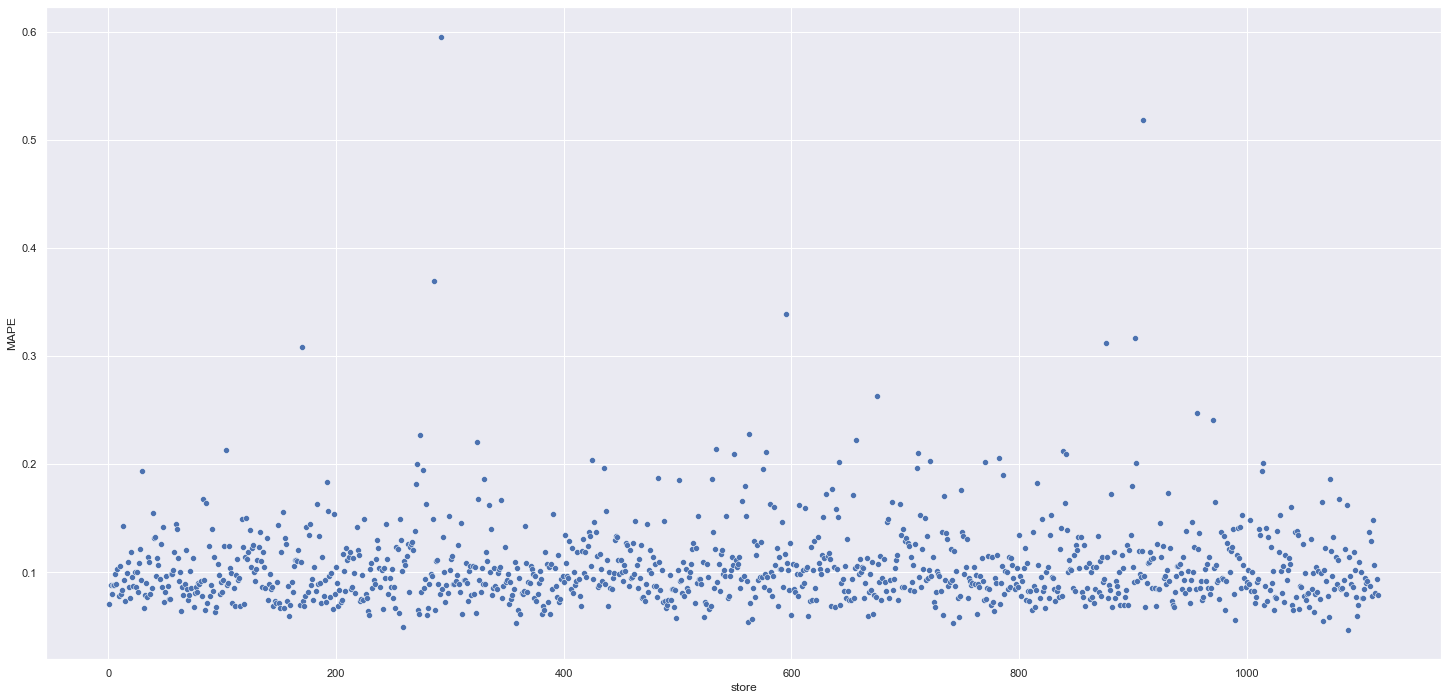

In [115]:
sns.scatterplot(x='store', y='MAPE', data=df10_03);

## 10.2 Total Performance

In [116]:
df10_04 = df10_03[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda row: np.sum(row), axis=0).reset_index().rename(columns={'index': 'scenario', 0:'values'})
df10_04['values'] = df10_04['values'].map('R${:,.2f}'.format)
df10_04

,scenario,values
0,predictions,"R$284,598,528.00"
1,worst_scenario,"R$283,805,888.11"
2,best_scenario,"R$285,391,206.20"


## 10.3 Machine Learning Performance

In [117]:
df10['error']    = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['sales']

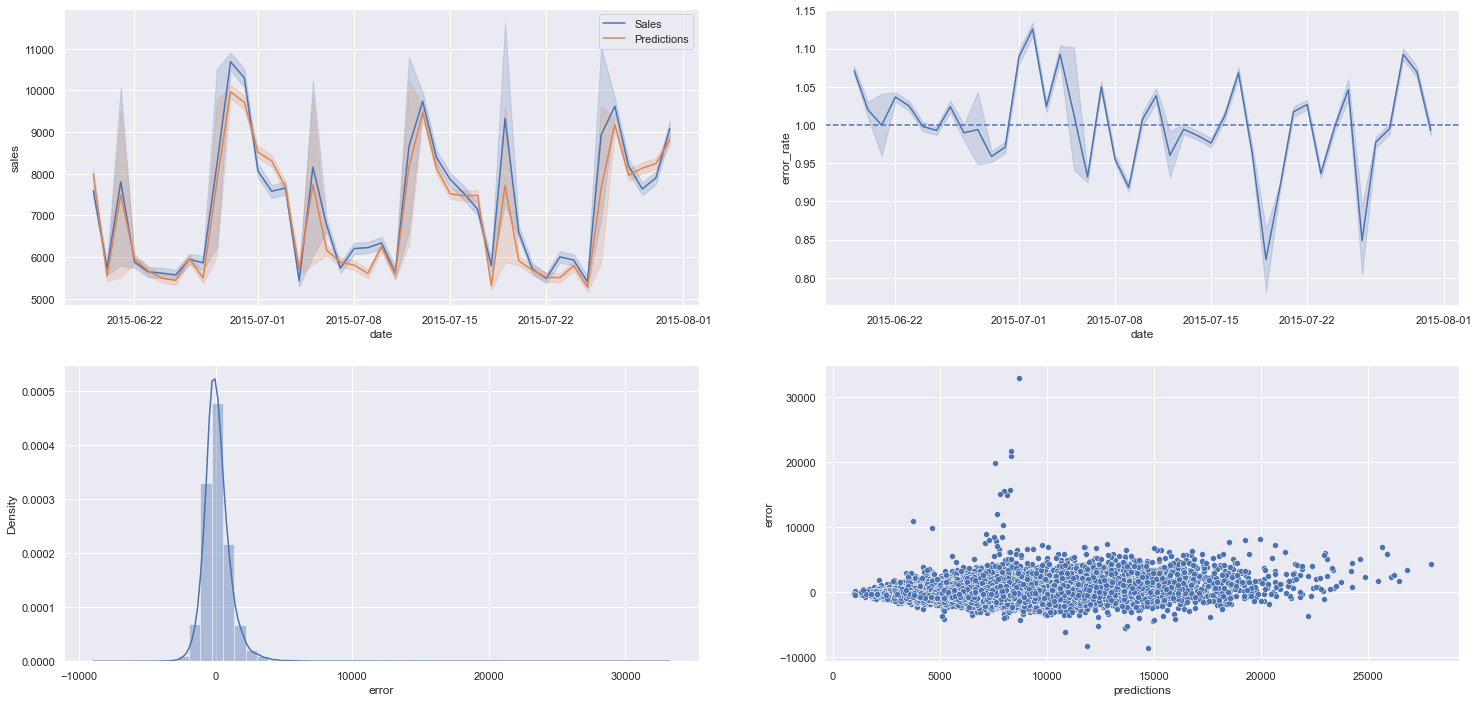

In [118]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df10, label='Sales');
sns.lineplot(x='date', y='predictions', data=df10, label='Predictions');

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df10);
plt.axhline(1, linestyle='--');

plt.subplot(2, 2, 3)
sns.distplot(df10['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(df10['predictions'], df10['error']);

# 11.0 Model Deploy 

In [120]:
pickle.dump(xgb_tuned, open('../models/1_flc_xgb_tuned.pkl', 'wb' ))

# 12.0 Testing

## 12.1 Class Rossmann

In [2]:
import sys
sys.path.append('../')

from webapp.rossmann.Rossmann import Rossmann

In [4]:
pipeline = Rossmann()

In [13]:
sales_test = pd.read_csv('../01-Data/test.csv', low_memory=False)
store_raw = pd.read_csv('../01-Data/store.csv', low_memory=False)

df_test = sales_test.merge(store_raw, how='left', on='Store')

# Data Cleaning
df1 = pipeline.data_cleaning(df_test)
# Feature Engineering
df2 = pipeline.feature_engineering(df1)
# Data Preparation
df3 = pipeline.data_preparation(df2)
# Prediction
#dfResponse = pipeline.get_prediction(model, testeRaw, df3)

..\webapp\rossmann\Rossmann.py:102: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [14]:
def get_prediction(model, df_test, test_data):
    # Prediction
    pred = model.predict(test_data)

    # Join pred into original Data
    original_data['prediction'] = np.expm1(pred)

    return original_data

In [15]:
model = pickle.load(open('../webapp/model/1_flc_xgb_tuned.pkl', 'rb'))
# Prediction
df_response = get_prediction(model, df_teste, df3)
df_response.head()

,id,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,...,year,month,day,week_of_year,year_week,competion_sinse,competion_time_month,promo_since,promo_time_week,prediction
0,1,1,4,2015-09-17,1.0,1,regular day,0,c,basic,...,2015,9,17,38,2015-37,2008-09-01,85,2015-09-14,0,4251.291016
1,2,3,4,2015-09-17,1.0,1,regular day,0,a,basic,...,2015,9,17,38,2015-37,2006-12-01,107,2011-03-28,233,6105.725098
2,3,7,4,2015-09-17,1.0,1,regular day,0,a,extended,...,2015,9,17,38,2015-37,2013-04-01,29,2015-09-14,0,6216.384277
3,4,8,4,2015-09-17,1.0,1,regular day,0,a,basic,...,2015,9,17,38,2015-37,2014-10-01,11,2015-09-14,0,5616.511719
4,5,9,4,2015-09-17,1.0,1,regular day,0,a,extended,...,2015,9,17,38,2015-37,2000-08-01,184,2015-09-14,0,6479.495117


## 12.2 API (localhost)

In [19]:
sales_test = pd.read_csv('../01-Data/test.csv', low_memory=False)
store_raw = pd.read_csv('../01-Data/store.csv', low_memory=False)

df_test = sales_test.merge(store_raw, how='left', on='Store')

store_list = [30, 14, 23]

# Choose Store for Prediction
df_test = df_test[df_test['Store'].isin(store_list)]

# Remove Closed Days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [20]:
# Convert DataFrame to JSON
data = json.dumps(df_test.to_dict(orient='records'))

In [21]:
## API Call
url = 'http://localhost:5000/rossmann/predict'
header = {'Content-Type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [22]:
df_response = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [23]:
df_response.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competion_sinse,competion_time_month,promo_since,promo_time_week,prediction
0,14,4,2015-09-17T00:00:00.000Z,1.0,1,regular day,0,a,basic,1300.0,...,2015,9,17,38,2015-37,2014-03-01T00:00:00.000Z,18,2011-09-26T00:00:00.000Z,207,6323.219727
1,23,4,2015-09-17T00:00:00.000Z,1.0,1,regular day,0,d,basic,4060.0,...,2015,9,17,38,2015-37,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,7890.851562
2,30,4,2015-09-17T00:00:00.000Z,1.0,1,regular day,0,a,basic,40.0,...,2015,9,17,38,2015-37,2014-02-01T00:00:00.000Z,19,2014-03-03T00:00:00.000Z,80,4946.782715
3,14,3,2015-09-16T00:00:00.000Z,1.0,1,regular day,0,a,basic,1300.0,...,2015,9,16,38,2015-37,2014-03-01T00:00:00.000Z,18,2011-09-26T00:00:00.000Z,207,6422.070312
4,23,3,2015-09-16T00:00:00.000Z,1.0,1,regular day,0,d,basic,4060.0,...,2015,9,16,38,2015-37,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,7532.273438
